# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.03091863 -0.23794214 -0.02249439  0.27883773] 0 1.0 False {}
state, action, reward, done, info: [-0.03567748 -0.04250664 -0.01691764 -0.02085416] 1 1.0 False {}
state, action, reward, done, info: [-0.03652761  0.15285379 -0.01733472 -0.31882642] 1 1.0 False {}
state, action, reward, done, info: [-0.03347053 -0.04201704 -0.02371125 -0.03166024] 0 1.0 False {}
state, action, reward, done, info: [-0.03431087  0.15343678 -0.02434445 -0.331729  ] 1 1.0 False {}
state, action, reward, done, info: [-0.03124214  0.34889664 -0.03097903 -0.63198848] 1 1.0 False {}
state, action, reward, done, info: [-0.02426421  0.54443679 -0.0436188  -0.93426436] 1 1.0 False {}
state, action, reward, done, info: [-0.01337547  0.74011915 -0.06230409 -1.24032858] 1 1.0 False {}
state, action, reward, done, info: [ 1.42691346e-03  9.35983314e-01 -8.71106622e-02 -1.55186033e+00] 1 1.0 False {}
state, action, reward, done, info: [ 0.02014658  1.13203526 -0.11814787 -1.87040133]

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    labelQs = tf.placeholder(tf.float32, [None], name='labelQs')
    return actions, states, targetQs, labelQs

In [7]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(action_size, hidden_size, states, actions, targetQs, labelQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    lossQtgt = tf.reduce_mean(tf.square(Qs - targetQs)) # next state, next action and nextQs
    lossQlbl = tf.reduce_mean(tf.square(Qs - labelQs)) # current state, action, and currentQs
    # lossQtgt_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
    #                                                                        labels=tf.nn.sigmoid(targetQs)))
    # lossQlbl_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
    #                                                                        labels=tf.nn.sigmoid(labelQs)))
    loss = lossQtgt + lossQlbl #+ lossQtgt_sigm + lossQlbl_sigm
    return actions_logits, loss, lossQtgt, lossQlbl

In [9]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.labelQs = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.lossQtgt, self.lossQlbl = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, labelQs=self.labelQs)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [13]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 1000              # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
memory.buffer[0]

[array([ 0.04816909, -0.02926551,  0.00024883,  0.0418731 ]),
 1,
 array([ 0.04758378,  0.16585287,  0.00108629, -0.25073131]),
 1.0,
 0.0]

In [17]:
# states, rewards, actions

In [18]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Testing
            action_logits = sess.run(model.actions_logits, feed_dict = {model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: states})
            labelQs = np.max(actions_logits, axis=1) # explore
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            loss, _, lossQlbl, lossQtgt = sess.run([model.loss, model.opt, model.lossQlbl, model.lossQtgt], 
                                                   feed_dict = {model.states: states,
                                                                model.actions: actions,
                                                                model.targetQs: targetQs,
                                                                model.labelQs: labelQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model5.ckpt')

Episode: 0 meanReward: 10.0000 meanLoss: 1.2835
Episode: 1 meanReward: 10.0000 meanLoss: 1.8111
Episode: 2 meanReward: 10.0000 meanLoss: 2.3252
Episode: 3 meanReward: 10.0000 meanLoss: 2.3325
Episode: 4 meanReward: 9.8000 meanLoss: 2.7088
Episode: 5 meanReward: 9.6667 meanLoss: 3.8410
Episode: 6 meanReward: 9.5714 meanLoss: 6.1198
Episode: 7 meanReward: 9.5000 meanLoss: 10.1193
Episode: 8 meanReward: 9.6667 meanLoss: 16.9811
Episode: 9 meanReward: 9.6000 meanLoss: 24.0447
Episode: 10 meanReward: 9.8182 meanLoss: 26.4667
Episode: 11 meanReward: 10.3333 meanLoss: 27.1927
Episode: 12 meanReward: 11.0000 meanLoss: 26.1822
Episode: 13 meanReward: 11.3571 meanLoss: 26.9730
Episode: 14 meanReward: 11.6000 meanLoss: 31.9418
Episode: 15 meanReward: 12.3750 meanLoss: 45.8226
Episode: 16 meanReward: 16.0000 meanLoss: 71.0579
Episode: 17 meanReward: 19.5000 meanLoss: 80.1798
Episode: 18 meanReward: 24.8947 meanLoss: 183.7984
Episode: 19 meanReward: 27.6500 meanLoss: 255.0010
Episode: 20 meanReward

Episode: 147 meanReward: 228.6486 meanLoss: 121200656.0000
Episode: 148 meanReward: 229.0604 meanLoss: 118805472.0000
Episode: 149 meanReward: 229.3667 meanLoss: 119292128.0000
Episode: 150 meanReward: 229.7020 meanLoss: 119227392.0000
Episode: 151 meanReward: 230.1579 meanLoss: 116207880.0000
Episode: 152 meanReward: 230.4837 meanLoss: 114677976.0000
Episode: 153 meanReward: 230.8247 meanLoss: 112753904.0000
Episode: 154 meanReward: 231.1548 meanLoss: 111283872.0000
Episode: 155 meanReward: 231.4103 meanLoss: 112731624.0000
Episode: 156 meanReward: 231.5669 meanLoss: 115499936.0000
Episode: 157 meanReward: 231.8418 meanLoss: 117748936.0000
Episode: 158 meanReward: 232.0314 meanLoss: 119961400.0000
Episode: 159 meanReward: 232.3500 meanLoss: 119897664.0000
Episode: 160 meanReward: 232.5963 meanLoss: 117460280.0000
Episode: 161 meanReward: 232.7963 meanLoss: 117460496.0000
Episode: 162 meanReward: 233.0368 meanLoss: 117198704.0000
Episode: 163 meanReward: 233.1768 meanLoss: 119163752.00

Episode: 286 meanReward: 249.9373 meanLoss: 112482664.0000
Episode: 287 meanReward: 250.0417 meanLoss: 111422832.0000
Episode: 288 meanReward: 250.1315 meanLoss: 113109752.0000
Episode: 289 meanReward: 250.1379 meanLoss: 116166088.0000
Episode: 290 meanReward: 250.1684 meanLoss: 119874680.0000
Episode: 291 meanReward: 250.2295 meanLoss: 121986536.0000
Episode: 292 meanReward: 250.3276 meanLoss: 122122096.0000
Episode: 293 meanReward: 250.3741 meanLoss: 119962904.0000
Episode: 294 meanReward: 250.4949 meanLoss: 118069120.0000
Episode: 295 meanReward: 250.5405 meanLoss: 116808784.0000
Episode: 296 meanReward: 250.6061 meanLoss: 118495000.0000
Episode: 297 meanReward: 250.6678 meanLoss: 118787704.0000
Episode: 298 meanReward: 250.6689 meanLoss: 121852368.0000
Episode: 299 meanReward: 250.7233 meanLoss: 122567240.0000
Episode: 300 meanReward: 250.7674 meanLoss: 122697936.0000
Episode: 301 meanReward: 250.8344 meanLoss: 122397584.0000
Episode: 302 meanReward: 250.8845 meanLoss: 120575936.00

Episode: 425 meanReward: 256.7629 meanLoss: 119657840.0000
Episode: 426 meanReward: 256.7963 meanLoss: 119368608.0000
Episode: 427 meanReward: 256.8762 meanLoss: 117721576.0000
Episode: 428 meanReward: 256.9394 meanLoss: 114836664.0000
Episode: 429 meanReward: 256.9651 meanLoss: 114972992.0000
Episode: 430 meanReward: 257.0557 meanLoss: 115394136.0000
Episode: 431 meanReward: 257.0671 meanLoss: 116641200.0000
Episode: 432 meanReward: 257.0924 meanLoss: 118958720.0000
Episode: 433 meanReward: 257.1521 meanLoss: 117497792.0000
Episode: 434 meanReward: 257.1609 meanLoss: 118709920.0000
Episode: 435 meanReward: 257.2339 meanLoss: 117749864.0000
Episode: 436 meanReward: 257.2998 meanLoss: 115806424.0000
Episode: 437 meanReward: 257.2877 meanLoss: 117746696.0000
Episode: 438 meanReward: 257.2984 meanLoss: 118079552.0000
Episode: 439 meanReward: 257.3250 meanLoss: 121280400.0000
Episode: 440 meanReward: 257.3537 meanLoss: 122470328.0000
Episode: 441 meanReward: 257.3778 meanLoss: 121227216.00

Episode: 564 meanReward: 260.4372 meanLoss: 121091560.0000
Episode: 565 meanReward: 260.4505 meanLoss: 121056880.0000
Episode: 566 meanReward: 260.4868 meanLoss: 121302088.0000
Episode: 567 meanReward: 260.4930 meanLoss: 120707456.0000
Episode: 568 meanReward: 260.4886 meanLoss: 121112800.0000
Episode: 569 meanReward: 260.5000 meanLoss: 120707440.0000
Episode: 570 meanReward: 260.5219 meanLoss: 121084168.0000
Episode: 571 meanReward: 260.5315 meanLoss: 120696320.0000
Episode: 572 meanReward: 260.5637 meanLoss: 118743840.0000
Episode: 573 meanReward: 260.5575 meanLoss: 119090888.0000
Episode: 574 meanReward: 260.5983 meanLoss: 119183984.0000
Episode: 575 meanReward: 260.6076 meanLoss: 118436272.0000
Episode: 576 meanReward: 260.6690 meanLoss: 118232120.0000
Episode: 577 meanReward: 260.7197 meanLoss: 114713024.0000
Episode: 578 meanReward: 260.7202 meanLoss: 114637584.0000
Episode: 579 meanReward: 260.7500 meanLoss: 114961064.0000
Episode: 580 meanReward: 260.7539 meanLoss: 117746488.00

Episode: 703 meanReward: 262.4332 meanLoss: 119741768.0000
Episode: 704 meanReward: 262.4440 meanLoss: 121259136.0000
Episode: 705 meanReward: 262.4575 meanLoss: 119476368.0000
Episode: 706 meanReward: 262.4668 meanLoss: 119068936.0000
Episode: 707 meanReward: 262.4435 meanLoss: 119800592.0000
Episode: 708 meanReward: 262.4711 meanLoss: 120081488.0000
Episode: 709 meanReward: 262.4873 meanLoss: 119426016.0000
Episode: 710 meanReward: 262.4923 meanLoss: 120381736.0000
Episode: 711 meanReward: 262.4874 meanLoss: 119537096.0000
Episode: 712 meanReward: 262.4965 meanLoss: 121267352.0000
Episode: 713 meanReward: 262.5266 meanLoss: 122289208.0000
Episode: 714 meanReward: 262.5133 meanLoss: 122048448.0000
Episode: 715 meanReward: 262.5433 meanLoss: 120571336.0000
Episode: 716 meanReward: 262.5593 meanLoss: 118982064.0000
Episode: 717 meanReward: 262.5752 meanLoss: 119084224.0000
Episode: 718 meanReward: 262.5883 meanLoss: 116750440.0000
Episode: 719 meanReward: 262.6125 meanLoss: 117209160.00

Episode: 842 meanReward: 263.8909 meanLoss: 118323272.0000
Episode: 843 meanReward: 263.9123 meanLoss: 117309976.0000
Episode: 844 meanReward: 263.9148 meanLoss: 117303464.0000
Episode: 845 meanReward: 263.9338 meanLoss: 116924784.0000
Episode: 846 meanReward: 263.9528 meanLoss: 116529328.0000
Episode: 847 meanReward: 263.9646 meanLoss: 117195640.0000
Episode: 848 meanReward: 263.9706 meanLoss: 117323784.0000
Episode: 849 meanReward: 263.9753 meanLoss: 118677416.0000
Episode: 850 meanReward: 263.9894 meanLoss: 119746400.0000
Episode: 851 meanReward: 263.9918 meanLoss: 120455216.0000
Episode: 852 meanReward: 264.0152 meanLoss: 119324384.0000
Episode: 853 meanReward: 264.0234 meanLoss: 117757080.0000
Episode: 854 meanReward: 264.0433 meanLoss: 116976664.0000
Episode: 855 meanReward: 264.0409 meanLoss: 115998160.0000
Episode: 856 meanReward: 264.0420 meanLoss: 118338816.0000
Episode: 857 meanReward: 264.0385 meanLoss: 119675168.0000
Episode: 858 meanReward: 264.0559 meanLoss: 121643184.00

Episode: 981 meanReward: 264.9745 meanLoss: 119024000.0000
Episode: 982 meanReward: 265.0010 meanLoss: 120049664.0000
Episode: 983 meanReward: 264.9990 meanLoss: 119596360.0000
Episode: 984 meanReward: 264.9959 meanLoss: 119183232.0000
Episode: 985 meanReward: 265.0000 meanLoss: 118671944.0000
Episode: 986 meanReward: 265.0132 meanLoss: 120766992.0000
Episode: 987 meanReward: 265.0182 meanLoss: 120857328.0000
Episode: 988 meanReward: 265.0263 meanLoss: 119876848.0000
Episode: 989 meanReward: 265.0495 meanLoss: 119194728.0000
Episode: 990 meanReward: 265.0757 meanLoss: 117909888.0000
Episode: 991 meanReward: 265.0948 meanLoss: 115377816.0000
Episode: 992 meanReward: 265.0876 meanLoss: 115377040.0000
Episode: 993 meanReward: 265.0785 meanLoss: 117672608.0000
Episode: 994 meanReward: 265.0603 meanLoss: 121806544.0000
Episode: 995 meanReward: 265.0904 meanLoss: 122522776.0000
Episode: 996 meanReward: 265.1113 meanLoss: 120050680.0000
Episode: 997 meanReward: 265.1062 meanLoss: 117761608.00

Episode: 1118 meanReward: 271.4710 meanLoss: 122180584.0000
Episode: 1119 meanReward: 271.4890 meanLoss: 122503296.0000
Episode: 1120 meanReward: 271.4740 meanLoss: 121557048.0000
Episode: 1121 meanReward: 271.4450 meanLoss: 121258640.0000
Episode: 1122 meanReward: 271.4450 meanLoss: 120880064.0000
Episode: 1123 meanReward: 271.4620 meanLoss: 120613176.0000
Episode: 1124 meanReward: 271.4410 meanLoss: 120184704.0000
Episode: 1125 meanReward: 271.4160 meanLoss: 120446944.0000
Episode: 1126 meanReward: 271.4050 meanLoss: 120804144.0000
Episode: 1127 meanReward: 271.4200 meanLoss: 121517616.0000
Episode: 1128 meanReward: 271.4480 meanLoss: 119409728.0000
Episode: 1129 meanReward: 271.4660 meanLoss: 116560152.0000
Episode: 1130 meanReward: 271.4540 meanLoss: 115340592.0000
Episode: 1131 meanReward: 271.4450 meanLoss: 117307600.0000
Episode: 1132 meanReward: 271.4640 meanLoss: 119419192.0000
Episode: 1133 meanReward: 271.4800 meanLoss: 120159984.0000
Episode: 1134 meanReward: 271.4560 meanL

Episode: 1255 meanReward: 271.4570 meanLoss: 121278408.0000
Episode: 1256 meanReward: 271.4790 meanLoss: 119519440.0000
Episode: 1257 meanReward: 271.4720 meanLoss: 118082592.0000
Episode: 1258 meanReward: 271.4920 meanLoss: 117782872.0000
Episode: 1259 meanReward: 271.4880 meanLoss: 119023824.0000
Episode: 1260 meanReward: 271.5010 meanLoss: 118439000.0000
Episode: 1261 meanReward: 271.4670 meanLoss: 118005480.0000
Episode: 1262 meanReward: 271.4770 meanLoss: 120229760.0000
Episode: 1263 meanReward: 271.4790 meanLoss: 119852632.0000
Episode: 1264 meanReward: 271.4840 meanLoss: 122500864.0000
Episode: 1265 meanReward: 271.4920 meanLoss: 121381456.0000
Episode: 1266 meanReward: 271.5050 meanLoss: 120210928.0000
Episode: 1267 meanReward: 271.4880 meanLoss: 120175296.0000
Episode: 1268 meanReward: 271.5030 meanLoss: 120089896.0000
Episode: 1269 meanReward: 271.5320 meanLoss: 118606168.0000
Episode: 1270 meanReward: 271.5400 meanLoss: 117542296.0000
Episode: 1271 meanReward: 271.5460 meanL

Episode: 1392 meanReward: 271.4900 meanLoss: 120135504.0000
Episode: 1393 meanReward: 271.4940 meanLoss: 119679544.0000
Episode: 1394 meanReward: 271.4920 meanLoss: 118264368.0000
Episode: 1395 meanReward: 271.4850 meanLoss: 117945712.0000
Episode: 1396 meanReward: 271.4920 meanLoss: 117098992.0000
Episode: 1397 meanReward: 271.5030 meanLoss: 119887160.0000
Episode: 1398 meanReward: 271.5340 meanLoss: 121076544.0000
Episode: 1399 meanReward: 271.5370 meanLoss: 121245080.0000
Episode: 1400 meanReward: 271.5250 meanLoss: 121078952.0000
Episode: 1401 meanReward: 271.4930 meanLoss: 122418696.0000
Episode: 1402 meanReward: 271.4480 meanLoss: 125443840.0000
Episode: 1403 meanReward: 271.4500 meanLoss: 126785240.0000
Episode: 1404 meanReward: 271.4840 meanLoss: 125418128.0000
Episode: 1405 meanReward: 271.4720 meanLoss: 121057984.0000
Episode: 1406 meanReward: 271.4390 meanLoss: 117952192.0000
Episode: 1407 meanReward: 271.4260 meanLoss: 116819464.0000
Episode: 1408 meanReward: 271.4100 meanL

Episode: 1529 meanReward: 271.4880 meanLoss: 120075280.0000
Episode: 1530 meanReward: 271.4520 meanLoss: 119725848.0000
Episode: 1531 meanReward: 271.4020 meanLoss: 119253904.0000
Episode: 1532 meanReward: 271.3990 meanLoss: 122649344.0000
Episode: 1533 meanReward: 271.4120 meanLoss: 122753216.0000
Episode: 1534 meanReward: 271.3980 meanLoss: 122722024.0000
Episode: 1535 meanReward: 271.3670 meanLoss: 122807688.0000
Episode: 1536 meanReward: 271.3380 meanLoss: 123226352.0000
Episode: 1537 meanReward: 271.3320 meanLoss: 124042912.0000
Episode: 1538 meanReward: 271.3410 meanLoss: 122601728.0000
Episode: 1539 meanReward: 271.3420 meanLoss: 120946016.0000
Episode: 1540 meanReward: 271.3610 meanLoss: 118447408.0000
Episode: 1541 meanReward: 271.3880 meanLoss: 116869376.0000
Episode: 1542 meanReward: 271.3970 meanLoss: 116118856.0000
Episode: 1543 meanReward: 271.4160 meanLoss: 115007824.0000
Episode: 1544 meanReward: 271.4170 meanLoss: 115218256.0000
Episode: 1545 meanReward: 271.4290 meanL

Episode: 1666 meanReward: 272.0580 meanLoss: 114545992.0000
Episode: 1667 meanReward: 272.0640 meanLoss: 107224768.0000
Episode: 1668 meanReward: 272.0810 meanLoss: 107173824.0000
Episode: 1669 meanReward: 272.0700 meanLoss: 108621000.0000
Episode: 1670 meanReward: 272.0890 meanLoss: 116028720.0000
Episode: 1671 meanReward: 272.0830 meanLoss: 119803256.0000
Episode: 1672 meanReward: 272.0680 meanLoss: 122009112.0000
Episode: 1673 meanReward: 272.0800 meanLoss: 120368904.0000
Episode: 1674 meanReward: 272.0960 meanLoss: 120892320.0000
Episode: 1675 meanReward: 272.1290 meanLoss: 118541576.0000
Episode: 1676 meanReward: 272.1300 meanLoss: 115928624.0000
Episode: 1677 meanReward: 272.1380 meanLoss: 116821576.0000
Episode: 1678 meanReward: 272.1470 meanLoss: 116579464.0000
Episode: 1679 meanReward: 272.1330 meanLoss: 119329992.0000
Episode: 1680 meanReward: 272.1370 meanLoss: 120136600.0000
Episode: 1681 meanReward: 272.1200 meanLoss: 121126656.0000
Episode: 1682 meanReward: 272.1370 meanL

Episode: 1803 meanReward: 272.1700 meanLoss: 117197864.0000
Episode: 1804 meanReward: 272.1800 meanLoss: 119158056.0000
Episode: 1805 meanReward: 272.1960 meanLoss: 120593464.0000
Episode: 1806 meanReward: 272.2020 meanLoss: 120826160.0000
Episode: 1807 meanReward: 272.1850 meanLoss: 121199864.0000
Episode: 1808 meanReward: 272.1930 meanLoss: 119659352.0000
Episode: 1809 meanReward: 272.1880 meanLoss: 117723264.0000
Episode: 1810 meanReward: 272.1850 meanLoss: 117625224.0000
Episode: 1811 meanReward: 272.1970 meanLoss: 117018744.0000
Episode: 1812 meanReward: 272.1670 meanLoss: 119400672.0000
Episode: 1813 meanReward: 272.1810 meanLoss: 120637688.0000
Episode: 1814 meanReward: 272.1860 meanLoss: 120890648.0000
Episode: 1815 meanReward: 272.1720 meanLoss: 121077520.0000
Episode: 1816 meanReward: 272.1690 meanLoss: 119896120.0000
Episode: 1817 meanReward: 272.1600 meanLoss: 121881328.0000
Episode: 1818 meanReward: 272.1770 meanLoss: 121015808.0000
Episode: 1819 meanReward: 272.1950 meanL

Episode: 1940 meanReward: 272.1680 meanLoss: 120176160.0000
Episode: 1941 meanReward: 272.1540 meanLoss: 121229056.0000
Episode: 1942 meanReward: 272.1500 meanLoss: 122380864.0000
Episode: 1943 meanReward: 272.1490 meanLoss: 123068128.0000
Episode: 1944 meanReward: 272.1280 meanLoss: 124566104.0000
Episode: 1945 meanReward: 272.1200 meanLoss: 125129944.0000
Episode: 1946 meanReward: 272.1060 meanLoss: 125472224.0000
Episode: 1947 meanReward: 272.1150 meanLoss: 123907648.0000
Episode: 1948 meanReward: 272.0980 meanLoss: 123097400.0000
Episode: 1949 meanReward: 272.0910 meanLoss: 122367344.0000
Episode: 1950 meanReward: 272.1120 meanLoss: 120606952.0000
Episode: 1951 meanReward: 272.1250 meanLoss: 118673560.0000
Episode: 1952 meanReward: 272.1520 meanLoss: 117565784.0000
Episode: 1953 meanReward: 272.1680 meanLoss: 116036448.0000
Episode: 1954 meanReward: 272.1570 meanLoss: 118522672.0000
Episode: 1955 meanReward: 272.1380 meanLoss: 120338352.0000
Episode: 1956 meanReward: 272.1360 meanL

Episode: 2077 meanReward: 272.3540 meanLoss: 116925584.0000
Episode: 2078 meanReward: 272.3560 meanLoss: 119449184.0000
Episode: 2079 meanReward: 272.3450 meanLoss: 118781272.0000
Episode: 2080 meanReward: 272.3580 meanLoss: 118050544.0000
Episode: 2081 meanReward: 272.3270 meanLoss: 117795456.0000
Episode: 2082 meanReward: 272.3400 meanLoss: 117656512.0000
Episode: 2083 meanReward: 272.3650 meanLoss: 116250792.0000
Episode: 2084 meanReward: 272.3540 meanLoss: 116829136.0000
Episode: 2085 meanReward: 272.3530 meanLoss: 116404792.0000
Episode: 2086 meanReward: 272.3480 meanLoss: 118636344.0000
Episode: 2087 meanReward: 272.3620 meanLoss: 120115320.0000
Episode: 2088 meanReward: 272.4490 meanLoss: 115507224.0000
Episode: 2089 meanReward: 272.4260 meanLoss: 109890624.0000
Episode: 2090 meanReward: 272.4070 meanLoss: 110934504.0000
Episode: 2091 meanReward: 272.3940 meanLoss: 112474760.0000
Episode: 2092 meanReward: 272.3900 meanLoss: 119001472.0000
Episode: 2093 meanReward: 272.3850 meanL

Episode: 2214 meanReward: 272.3770 meanLoss: 122057568.0000
Episode: 2215 meanReward: 272.3770 meanLoss: 119042136.0000
Episode: 2216 meanReward: 272.3840 meanLoss: 118477144.0000
Episode: 2217 meanReward: 272.3520 meanLoss: 118516056.0000
Episode: 2218 meanReward: 272.3460 meanLoss: 121667888.0000
Episode: 2219 meanReward: 272.3680 meanLoss: 120806824.0000
Episode: 2220 meanReward: 272.3910 meanLoss: 120033216.0000
Episode: 2221 meanReward: 272.4020 meanLoss: 116469072.0000
Episode: 2222 meanReward: 272.4110 meanLoss: 114094496.0000
Episode: 2223 meanReward: 272.3910 meanLoss: 115266576.0000
Episode: 2224 meanReward: 272.3950 meanLoss: 115368320.0000
Episode: 2225 meanReward: 272.4050 meanLoss: 116577288.0000
Episode: 2226 meanReward: 272.4250 meanLoss: 116077984.0000
Episode: 2227 meanReward: 272.4580 meanLoss: 115279176.0000
Episode: 2228 meanReward: 272.4460 meanLoss: 114896440.0000
Episode: 2229 meanReward: 272.4210 meanLoss: 116748928.0000
Episode: 2230 meanReward: 272.4200 meanL

Episode: 2351 meanReward: 272.0780 meanLoss: 120061984.0000
Episode: 2352 meanReward: 272.0820 meanLoss: 119872552.0000
Episode: 2353 meanReward: 272.1010 meanLoss: 120296152.0000
Episode: 2354 meanReward: 272.1020 meanLoss: 117361688.0000
Episode: 2355 meanReward: 272.0920 meanLoss: 117810784.0000
Episode: 2356 meanReward: 272.0720 meanLoss: 118277312.0000
Episode: 2357 meanReward: 272.0830 meanLoss: 118763336.0000
Episode: 2358 meanReward: 272.0660 meanLoss: 122271376.0000
Episode: 2359 meanReward: 272.0940 meanLoss: 121781280.0000
Episode: 2360 meanReward: 272.0870 meanLoss: 120934128.0000
Episode: 2361 meanReward: 272.1010 meanLoss: 120333464.0000
Episode: 2362 meanReward: 272.1210 meanLoss: 117604712.0000
Episode: 2363 meanReward: 272.1510 meanLoss: 116307656.0000
Episode: 2364 meanReward: 272.1300 meanLoss: 115555976.0000
Episode: 2365 meanReward: 272.1520 meanLoss: 117113832.0000
Episode: 2366 meanReward: 272.1310 meanLoss: 120314096.0000
Episode: 2367 meanReward: 272.1150 meanL

Episode: 2488 meanReward: 272.1570 meanLoss: 118620984.0000
Episode: 2489 meanReward: 272.1650 meanLoss: 118678984.0000
Episode: 2490 meanReward: 272.1790 meanLoss: 118007088.0000
Episode: 2491 meanReward: 272.1500 meanLoss: 117879760.0000
Episode: 2492 meanReward: 272.1620 meanLoss: 117502184.0000
Episode: 2493 meanReward: 272.1670 meanLoss: 116722288.0000
Episode: 2494 meanReward: 272.1760 meanLoss: 116510752.0000
Episode: 2495 meanReward: 272.1450 meanLoss: 116441536.0000
Episode: 2496 meanReward: 272.1580 meanLoss: 117107872.0000
Episode: 2497 meanReward: 272.1310 meanLoss: 116929712.0000
Episode: 2498 meanReward: 272.1340 meanLoss: 120281312.0000
Episode: 2499 meanReward: 272.1220 meanLoss: 120099968.0000
Episode: 2500 meanReward: 272.1220 meanLoss: 120853224.0000
Episode: 2501 meanReward: 272.1320 meanLoss: 120582128.0000
Episode: 2502 meanReward: 272.1200 meanLoss: 120934416.0000
Episode: 2503 meanReward: 272.1440 meanLoss: 120326568.0000
Episode: 2504 meanReward: 272.1580 meanL

Episode: 2625 meanReward: 271.9140 meanLoss: 118966592.0000
Episode: 2626 meanReward: 271.9120 meanLoss: 119390232.0000
Episode: 2627 meanReward: 271.9190 meanLoss: 121275336.0000
Episode: 2628 meanReward: 271.8570 meanLoss: 120830304.0000
Episode: 2629 meanReward: 271.8650 meanLoss: 120508760.0000
Episode: 2630 meanReward: 271.8830 meanLoss: 117516040.0000
Episode: 2631 meanReward: 271.8780 meanLoss: 116631608.0000
Episode: 2632 meanReward: 271.8990 meanLoss: 115687504.0000
Episode: 2633 meanReward: 271.9120 meanLoss: 117134144.0000
Episode: 2634 meanReward: 271.8820 meanLoss: 121299208.0000
Episode: 2635 meanReward: 271.8560 meanLoss: 122494080.0000
Episode: 2636 meanReward: 271.8500 meanLoss: 122001456.0000
Episode: 2637 meanReward: 271.8340 meanLoss: 122733760.0000
Episode: 2638 meanReward: 271.8470 meanLoss: 120434776.0000
Episode: 2639 meanReward: 271.8820 meanLoss: 117119304.0000
Episode: 2640 meanReward: 271.8900 meanLoss: 116088384.0000
Episode: 2641 meanReward: 271.8550 meanL

Episode: 2762 meanReward: 271.9260 meanLoss: 118107616.0000
Episode: 2763 meanReward: 271.9350 meanLoss: 116478672.0000
Episode: 2764 meanReward: 271.9260 meanLoss: 117140448.0000
Episode: 2765 meanReward: 271.9050 meanLoss: 117570960.0000
Episode: 2766 meanReward: 271.9110 meanLoss: 117343208.0000
Episode: 2767 meanReward: 271.9380 meanLoss: 117523160.0000
Episode: 2768 meanReward: 271.9220 meanLoss: 116677760.0000
Episode: 2769 meanReward: 271.9280 meanLoss: 116689280.0000
Episode: 2770 meanReward: 271.9360 meanLoss: 115602224.0000
Episode: 2771 meanReward: 271.9040 meanLoss: 116932400.0000
Episode: 2772 meanReward: 271.9280 meanLoss: 117558872.0000
Episode: 2773 meanReward: 271.8830 meanLoss: 119308984.0000
Episode: 2774 meanReward: 271.9050 meanLoss: 120699584.0000
Episode: 2775 meanReward: 271.9200 meanLoss: 118813024.0000
Episode: 2776 meanReward: 271.9090 meanLoss: 121223792.0000
Episode: 2777 meanReward: 271.9170 meanLoss: 119978792.0000
Episode: 2778 meanReward: 271.8730 meanL

Episode: 2899 meanReward: 272.0610 meanLoss: 120771256.0000
Episode: 2900 meanReward: 272.0380 meanLoss: 122356168.0000
Episode: 2901 meanReward: 272.0490 meanLoss: 121926256.0000
Episode: 2902 meanReward: 272.0740 meanLoss: 120714624.0000
Episode: 2903 meanReward: 272.0780 meanLoss: 119680216.0000
Episode: 2904 meanReward: 272.0830 meanLoss: 115751296.0000
Episode: 2905 meanReward: 272.0370 meanLoss: 115053176.0000
Episode: 2906 meanReward: 272.0140 meanLoss: 117406384.0000
Episode: 2907 meanReward: 272.0330 meanLoss: 118498624.0000
Episode: 2908 meanReward: 272.0720 meanLoss: 119182592.0000
Episode: 2909 meanReward: 272.0790 meanLoss: 118357872.0000
Episode: 2910 meanReward: 272.0920 meanLoss: 118098656.0000
Episode: 2911 meanReward: 272.0970 meanLoss: 117761728.0000
Episode: 2912 meanReward: 272.0740 meanLoss: 120242528.0000
Episode: 2913 meanReward: 272.0750 meanLoss: 122559536.0000
Episode: 2914 meanReward: 272.0700 meanLoss: 121638424.0000
Episode: 2915 meanReward: 272.0560 meanL

Episode: 3036 meanReward: 272.2320 meanLoss: 122065632.0000
Episode: 3037 meanReward: 272.2230 meanLoss: 119705824.0000
Episode: 3038 meanReward: 272.2200 meanLoss: 116574328.0000
Episode: 3039 meanReward: 272.2230 meanLoss: 115501192.0000
Episode: 3040 meanReward: 272.2090 meanLoss: 117074880.0000
Episode: 3041 meanReward: 272.2260 meanLoss: 118263352.0000
Episode: 3042 meanReward: 272.2220 meanLoss: 119715368.0000
Episode: 3043 meanReward: 272.2210 meanLoss: 120971400.0000
Episode: 3044 meanReward: 272.2120 meanLoss: 118748032.0000
Episode: 3045 meanReward: 272.2050 meanLoss: 118793832.0000
Episode: 3046 meanReward: 272.1880 meanLoss: 117957712.0000
Episode: 3047 meanReward: 272.1840 meanLoss: 118413880.0000
Episode: 3048 meanReward: 272.1700 meanLoss: 119531032.0000
Episode: 3049 meanReward: 272.1180 meanLoss: 122344232.0000
Episode: 3050 meanReward: 272.1200 meanLoss: 122803776.0000
Episode: 3051 meanReward: 272.1250 meanLoss: 123347152.0000
Episode: 3052 meanReward: 272.1900 meanL

Episode: 3173 meanReward: 272.0880 meanLoss: 117775312.0000
Episode: 3174 meanReward: 272.0980 meanLoss: 116218160.0000
Episode: 3175 meanReward: 272.1120 meanLoss: 116962936.0000
Episode: 3176 meanReward: 272.1210 meanLoss: 117874936.0000
Episode: 3177 meanReward: 272.1420 meanLoss: 117446304.0000
Episode: 3178 meanReward: 272.1660 meanLoss: 118100136.0000
Episode: 3179 meanReward: 272.1600 meanLoss: 115625504.0000
Episode: 3180 meanReward: 272.1570 meanLoss: 115676728.0000
Episode: 3181 meanReward: 272.1740 meanLoss: 116409176.0000
Episode: 3182 meanReward: 272.1690 meanLoss: 119184768.0000
Episode: 3183 meanReward: 272.1650 meanLoss: 121251400.0000
Episode: 3184 meanReward: 272.1620 meanLoss: 120809264.0000
Episode: 3185 meanReward: 272.1760 meanLoss: 119794552.0000
Episode: 3186 meanReward: 272.2010 meanLoss: 117509208.0000
Episode: 3187 meanReward: 272.1930 meanLoss: 116243000.0000
Episode: 3188 meanReward: 272.2170 meanLoss: 115686736.0000
Episode: 3189 meanReward: 272.1850 meanL

Episode: 3310 meanReward: 272.3310 meanLoss: 124862088.0000
Episode: 3311 meanReward: 272.3330 meanLoss: 123581504.0000
Episode: 3312 meanReward: 272.3330 meanLoss: 121606328.0000
Episode: 3313 meanReward: 272.3380 meanLoss: 120534648.0000
Episode: 3314 meanReward: 272.3160 meanLoss: 120073136.0000
Episode: 3315 meanReward: 272.2950 meanLoss: 121637688.0000
Episode: 3316 meanReward: 272.2970 meanLoss: 122125464.0000
Episode: 3317 meanReward: 272.3010 meanLoss: 122126304.0000
Episode: 3318 meanReward: 272.3020 meanLoss: 120377416.0000
Episode: 3319 meanReward: 272.3290 meanLoss: 118524504.0000
Episode: 3320 meanReward: 272.3310 meanLoss: 117326360.0000
Episode: 3321 meanReward: 272.3710 meanLoss: 116469008.0000
Episode: 3322 meanReward: 272.3820 meanLoss: 114291280.0000
Episode: 3323 meanReward: 272.3750 meanLoss: 115918736.0000
Episode: 3324 meanReward: 272.3620 meanLoss: 117538240.0000
Episode: 3325 meanReward: 272.3680 meanLoss: 119598848.0000
Episode: 3326 meanReward: 272.3640 meanL

Episode: 3447 meanReward: 272.2440 meanLoss: 115994248.0000
Episode: 3448 meanReward: 272.2550 meanLoss: 117621528.0000
Episode: 3449 meanReward: 272.2560 meanLoss: 120773632.0000
Episode: 3450 meanReward: 272.2520 meanLoss: 122135704.0000
Episode: 3451 meanReward: 272.2560 meanLoss: 121414736.0000
Episode: 3452 meanReward: 272.2680 meanLoss: 118390912.0000
Episode: 3453 meanReward: 272.2610 meanLoss: 116556096.0000
Episode: 3454 meanReward: 272.3120 meanLoss: 112218672.0000
Episode: 3455 meanReward: 272.3180 meanLoss: 108448944.0000
Episode: 3456 meanReward: 272.3200 meanLoss: 111995536.0000
Episode: 3457 meanReward: 272.3260 meanLoss: 112793216.0000
Episode: 3458 meanReward: 272.3360 meanLoss: 119820512.0000
Episode: 3459 meanReward: 272.3490 meanLoss: 120761968.0000
Episode: 3460 meanReward: 272.3330 meanLoss: 118430392.0000
Episode: 3461 meanReward: 272.3370 meanLoss: 117231576.0000
Episode: 3462 meanReward: 272.3330 meanLoss: 115943696.0000
Episode: 3463 meanReward: 272.3150 meanL

Episode: 3584 meanReward: 272.2300 meanLoss: 120392536.0000
Episode: 3585 meanReward: 272.2130 meanLoss: 119472248.0000
Episode: 3586 meanReward: 272.2630 meanLoss: 115732728.0000
Episode: 3587 meanReward: 272.2850 meanLoss: 111284536.0000
Episode: 3588 meanReward: 272.3180 meanLoss: 109666888.0000
Episode: 3589 meanReward: 272.3210 meanLoss: 108696408.0000
Episode: 3590 meanReward: 272.3210 meanLoss: 115931104.0000
Episode: 3591 meanReward: 272.3080 meanLoss: 119104112.0000
Episode: 3592 meanReward: 272.3180 meanLoss: 121524104.0000
Episode: 3593 meanReward: 272.3030 meanLoss: 122023320.0000
Episode: 3594 meanReward: 272.2920 meanLoss: 120315944.0000
Episode: 3595 meanReward: 272.2970 meanLoss: 119419392.0000
Episode: 3596 meanReward: 272.2930 meanLoss: 119088560.0000
Episode: 3597 meanReward: 272.3140 meanLoss: 119204720.0000
Episode: 3598 meanReward: 272.3260 meanLoss: 118516096.0000
Episode: 3599 meanReward: 272.3420 meanLoss: 117557920.0000
Episode: 3600 meanReward: 272.3410 meanL

Episode: 3721 meanReward: 272.2190 meanLoss: 122439808.0000
Episode: 3722 meanReward: 272.2190 meanLoss: 121878656.0000
Episode: 3723 meanReward: 272.2010 meanLoss: 122646120.0000
Episode: 3724 meanReward: 272.1920 meanLoss: 121644680.0000
Episode: 3725 meanReward: 272.1990 meanLoss: 120711736.0000
Episode: 3726 meanReward: 272.2100 meanLoss: 120277312.0000
Episode: 3727 meanReward: 272.1940 meanLoss: 117791536.0000
Episode: 3728 meanReward: 272.2240 meanLoss: 116825792.0000
Episode: 3729 meanReward: 272.2220 meanLoss: 114940480.0000
Episode: 3730 meanReward: 272.2080 meanLoss: 115964296.0000
Episode: 3731 meanReward: 272.2100 meanLoss: 117853392.0000
Episode: 3732 meanReward: 272.2130 meanLoss: 121316104.0000
Episode: 3733 meanReward: 272.2780 meanLoss: 119659680.0000
Episode: 3734 meanReward: 272.2710 meanLoss: 112825744.0000
Episode: 3735 meanReward: 272.2520 meanLoss: 111971528.0000
Episode: 3736 meanReward: 272.2610 meanLoss: 110305328.0000
Episode: 3737 meanReward: 272.2450 meanL

Episode: 3858 meanReward: 271.9130 meanLoss: 117216608.0000
Episode: 3859 meanReward: 271.8760 meanLoss: 120454424.0000
Episode: 3860 meanReward: 271.8700 meanLoss: 120629560.0000
Episode: 3861 meanReward: 271.8530 meanLoss: 122374552.0000
Episode: 3862 meanReward: 271.8190 meanLoss: 124347624.0000
Episode: 3863 meanReward: 271.8190 meanLoss: 123550200.0000
Episode: 3864 meanReward: 271.8520 meanLoss: 122132000.0000
Episode: 3865 meanReward: 271.8680 meanLoss: 119938368.0000
Episode: 3866 meanReward: 271.9010 meanLoss: 114712192.0000
Episode: 3867 meanReward: 271.8740 meanLoss: 110703736.0000
Episode: 3868 meanReward: 271.8870 meanLoss: 113726008.0000
Episode: 3869 meanReward: 271.8730 meanLoss: 115736544.0000
Episode: 3870 meanReward: 271.8650 meanLoss: 120505936.0000
Episode: 3871 meanReward: 271.8400 meanLoss: 121714640.0000
Episode: 3872 meanReward: 271.8220 meanLoss: 122912312.0000
Episode: 3873 meanReward: 271.8210 meanLoss: 122274224.0000
Episode: 3874 meanReward: 271.8360 meanL

Episode: 3995 meanReward: 271.8140 meanLoss: 116112864.0000
Episode: 3996 meanReward: 271.8000 meanLoss: 115888112.0000
Episode: 3997 meanReward: 271.7670 meanLoss: 120055264.0000
Episode: 3998 meanReward: 271.7860 meanLoss: 121032216.0000
Episode: 3999 meanReward: 271.7910 meanLoss: 121245672.0000
Episode: 4000 meanReward: 271.7700 meanLoss: 119672864.0000
Episode: 4001 meanReward: 271.7750 meanLoss: 117130912.0000
Episode: 4002 meanReward: 271.7550 meanLoss: 119781416.0000
Episode: 4003 meanReward: 271.7810 meanLoss: 120878512.0000
Episode: 4004 meanReward: 271.7720 meanLoss: 121734112.0000
Episode: 4005 meanReward: 271.7570 meanLoss: 123902416.0000
Episode: 4006 meanReward: 271.7400 meanLoss: 123006624.0000
Episode: 4007 meanReward: 271.7240 meanLoss: 123656816.0000
Episode: 4008 meanReward: 271.6950 meanLoss: 120021960.0000
Episode: 4009 meanReward: 271.6810 meanLoss: 117619232.0000
Episode: 4010 meanReward: 271.6910 meanLoss: 116759832.0000
Episode: 4011 meanReward: 271.6880 meanL

Episode: 4132 meanReward: 271.5840 meanLoss: 119575880.0000
Episode: 4133 meanReward: 271.5760 meanLoss: 119493760.0000
Episode: 4134 meanReward: 271.5920 meanLoss: 119544864.0000
Episode: 4135 meanReward: 271.5800 meanLoss: 118721984.0000
Episode: 4136 meanReward: 271.5340 meanLoss: 118742760.0000
Episode: 4137 meanReward: 271.5230 meanLoss: 119302256.0000
Episode: 4138 meanReward: 271.5160 meanLoss: 122100904.0000
Episode: 4139 meanReward: 271.5080 meanLoss: 121329656.0000
Episode: 4140 meanReward: 271.5100 meanLoss: 122399968.0000
Episode: 4141 meanReward: 271.4770 meanLoss: 122130496.0000
Episode: 4142 meanReward: 271.5710 meanLoss: 118288552.0000
Episode: 4143 meanReward: 271.5850 meanLoss: 110288536.0000
Episode: 4144 meanReward: 271.5470 meanLoss: 110486872.0000
Episode: 4145 meanReward: 271.5440 meanLoss: 109152784.0000
Episode: 4146 meanReward: 271.5470 meanLoss: 116610968.0000
Episode: 4147 meanReward: 271.5400 meanLoss: 120714160.0000
Episode: 4148 meanReward: 271.5550 meanL

Episode: 4269 meanReward: 271.3070 meanLoss: 119911080.0000
Episode: 4270 meanReward: 271.3040 meanLoss: 118662352.0000
Episode: 4271 meanReward: 271.2870 meanLoss: 120264144.0000
Episode: 4272 meanReward: 271.2750 meanLoss: 120325880.0000
Episode: 4273 meanReward: 271.2850 meanLoss: 119432912.0000
Episode: 4274 meanReward: 271.3310 meanLoss: 118987984.0000
Episode: 4275 meanReward: 271.3380 meanLoss: 116061760.0000
Episode: 4276 meanReward: 271.3380 meanLoss: 115080416.0000
Episode: 4277 meanReward: 271.3300 meanLoss: 117080688.0000
Episode: 4278 meanReward: 271.3150 meanLoss: 120760680.0000
Episode: 4279 meanReward: 271.3280 meanLoss: 121871760.0000
Episode: 4280 meanReward: 271.3120 meanLoss: 122035584.0000
Episode: 4281 meanReward: 271.3070 meanLoss: 121106344.0000
Episode: 4282 meanReward: 271.3060 meanLoss: 120342744.0000
Episode: 4283 meanReward: 271.3310 meanLoss: 119359688.0000
Episode: 4284 meanReward: 271.3210 meanLoss: 118302808.0000
Episode: 4285 meanReward: 271.3310 meanL

Episode: 4406 meanReward: 271.8220 meanLoss: 121620784.0000
Episode: 4407 meanReward: 271.8130 meanLoss: 119378832.0000
Episode: 4408 meanReward: 271.8250 meanLoss: 117929360.0000
Episode: 4409 meanReward: 271.8130 meanLoss: 117950008.0000
Episode: 4410 meanReward: 271.8000 meanLoss: 116237272.0000
Episode: 4411 meanReward: 271.8460 meanLoss: 117060472.0000
Episode: 4412 meanReward: 271.8440 meanLoss: 116222728.0000
Episode: 4413 meanReward: 271.8750 meanLoss: 116766240.0000
Episode: 4414 meanReward: 271.8960 meanLoss: 114255584.0000
Episode: 4415 meanReward: 271.8940 meanLoss: 114844032.0000
Episode: 4416 meanReward: 271.9010 meanLoss: 115350720.0000
Episode: 4417 meanReward: 271.9060 meanLoss: 116440984.0000
Episode: 4418 meanReward: 271.9090 meanLoss: 117455304.0000
Episode: 4419 meanReward: 271.9010 meanLoss: 117136752.0000
Episode: 4420 meanReward: 271.8820 meanLoss: 117803384.0000
Episode: 4421 meanReward: 271.8850 meanLoss: 121267816.0000
Episode: 4422 meanReward: 271.8780 meanL

Episode: 4543 meanReward: 271.9130 meanLoss: 118354464.0000
Episode: 4544 meanReward: 271.9090 meanLoss: 120328528.0000
Episode: 4545 meanReward: 271.9470 meanLoss: 119555040.0000
Episode: 4546 meanReward: 271.9280 meanLoss: 119107168.0000
Episode: 4547 meanReward: 271.9110 meanLoss: 119649248.0000
Episode: 4548 meanReward: 271.8930 meanLoss: 119419776.0000
Episode: 4549 meanReward: 271.8900 meanLoss: 120942712.0000
Episode: 4550 meanReward: 271.8940 meanLoss: 119650808.0000
Episode: 4551 meanReward: 271.8770 meanLoss: 119358680.0000
Episode: 4552 meanReward: 271.8900 meanLoss: 119828056.0000
Episode: 4553 meanReward: 271.9000 meanLoss: 120668056.0000
Episode: 4554 meanReward: 271.8980 meanLoss: 121106664.0000
Episode: 4555 meanReward: 271.8900 meanLoss: 120704928.0000
Episode: 4556 meanReward: 271.8860 meanLoss: 121034432.0000
Episode: 4557 meanReward: 271.8660 meanLoss: 122016816.0000
Episode: 4558 meanReward: 271.8500 meanLoss: 124350880.0000
Episode: 4559 meanReward: 271.8420 meanL

Episode: 4680 meanReward: 271.9270 meanLoss: 117631672.0000
Episode: 4681 meanReward: 271.9060 meanLoss: 116232376.0000
Episode: 4682 meanReward: 271.9300 meanLoss: 117219576.0000
Episode: 4683 meanReward: 271.9230 meanLoss: 117029992.0000
Episode: 4684 meanReward: 271.9300 meanLoss: 115807568.0000
Episode: 4685 meanReward: 271.9280 meanLoss: 112968688.0000
Episode: 4686 meanReward: 271.9140 meanLoss: 114311104.0000
Episode: 4687 meanReward: 271.9300 meanLoss: 114673584.0000
Episode: 4688 meanReward: 271.9050 meanLoss: 117130296.0000
Episode: 4689 meanReward: 271.9140 meanLoss: 118232024.0000
Episode: 4690 meanReward: 271.9090 meanLoss: 119003360.0000
Episode: 4691 meanReward: 271.8880 meanLoss: 121213248.0000
Episode: 4692 meanReward: 271.8960 meanLoss: 119762496.0000
Episode: 4693 meanReward: 271.8990 meanLoss: 120320208.0000
Episode: 4694 meanReward: 271.9010 meanLoss: 119929264.0000
Episode: 4695 meanReward: 271.8910 meanLoss: 120403672.0000
Episode: 4696 meanReward: 271.9310 meanL

Episode: 4817 meanReward: 272.0320 meanLoss: 118974912.0000
Episode: 4818 meanReward: 272.0510 meanLoss: 118248000.0000
Episode: 4819 meanReward: 272.0690 meanLoss: 116925576.0000
Episode: 4820 meanReward: 272.0740 meanLoss: 117545600.0000
Episode: 4821 meanReward: 272.0910 meanLoss: 116259376.0000
Episode: 4822 meanReward: 272.0530 meanLoss: 117008600.0000
Episode: 4823 meanReward: 272.0560 meanLoss: 117044184.0000
Episode: 4824 meanReward: 272.0410 meanLoss: 116895912.0000
Episode: 4825 meanReward: 272.0360 meanLoss: 119111352.0000
Episode: 4826 meanReward: 272.0460 meanLoss: 119394416.0000
Episode: 4827 meanReward: 272.0700 meanLoss: 121649848.0000
Episode: 4828 meanReward: 272.0990 meanLoss: 121297512.0000
Episode: 4829 meanReward: 272.1330 meanLoss: 119323992.0000
Episode: 4830 meanReward: 272.1370 meanLoss: 117899832.0000
Episode: 4831 meanReward: 272.1400 meanLoss: 116400680.0000
Episode: 4832 meanReward: 272.1380 meanLoss: 116063976.0000
Episode: 4833 meanReward: 272.1520 meanL

Episode: 4954 meanReward: 272.3670 meanLoss: 117431688.0000
Episode: 4955 meanReward: 272.3750 meanLoss: 116006568.0000
Episode: 4956 meanReward: 272.3670 meanLoss: 115267968.0000
Episode: 4957 meanReward: 272.3460 meanLoss: 116124816.0000
Episode: 4958 meanReward: 272.3140 meanLoss: 117323960.0000
Episode: 4959 meanReward: 272.2700 meanLoss: 118029376.0000
Episode: 4960 meanReward: 272.2620 meanLoss: 118940472.0000
Episode: 4961 meanReward: 272.2700 meanLoss: 117191880.0000
Episode: 4962 meanReward: 272.2690 meanLoss: 117247712.0000
Episode: 4963 meanReward: 272.2710 meanLoss: 118474000.0000
Episode: 4964 meanReward: 272.2870 meanLoss: 117064376.0000
Episode: 4965 meanReward: 272.2650 meanLoss: 118852936.0000
Episode: 4966 meanReward: 272.2720 meanLoss: 119958736.0000
Episode: 4967 meanReward: 272.2700 meanLoss: 120651888.0000
Episode: 4968 meanReward: 272.2610 meanLoss: 122921616.0000
Episode: 4969 meanReward: 272.2380 meanLoss: 123003448.0000
Episode: 4970 meanReward: 272.2310 meanL

Episode: 5091 meanReward: 272.4910 meanLoss: 113576864.0000
Episode: 5092 meanReward: 272.5290 meanLoss: 115306704.0000
Episode: 5093 meanReward: 272.5040 meanLoss: 114649120.0000
Episode: 5094 meanReward: 272.5240 meanLoss: 112846080.0000
Episode: 5095 meanReward: 272.5290 meanLoss: 112308952.0000
Episode: 5096 meanReward: 272.5150 meanLoss: 116722768.0000
Episode: 5097 meanReward: 272.5140 meanLoss: 118322104.0000
Episode: 5098 meanReward: 272.5180 meanLoss: 118920088.0000
Episode: 5099 meanReward: 272.5210 meanLoss: 120589200.0000
Episode: 5100 meanReward: 272.5200 meanLoss: 118404504.0000
Episode: 5101 meanReward: 272.5340 meanLoss: 118796664.0000
Episode: 5102 meanReward: 272.5590 meanLoss: 118683712.0000
Episode: 5103 meanReward: 272.5620 meanLoss: 117784296.0000
Episode: 5104 meanReward: 272.5640 meanLoss: 118262584.0000
Episode: 5105 meanReward: 272.5840 meanLoss: 118085512.0000
Episode: 5106 meanReward: 272.5870 meanLoss: 117418640.0000
Episode: 5107 meanReward: 272.6140 meanL

Episode: 5228 meanReward: 272.7120 meanLoss: 115898664.0000
Episode: 5229 meanReward: 272.7250 meanLoss: 116458864.0000
Episode: 5230 meanReward: 272.6790 meanLoss: 118271432.0000
Episode: 5231 meanReward: 272.6890 meanLoss: 119584608.0000
Episode: 5232 meanReward: 272.6690 meanLoss: 120071760.0000
Episode: 5233 meanReward: 272.6450 meanLoss: 121845752.0000
Episode: 5234 meanReward: 272.6640 meanLoss: 120411792.0000
Episode: 5235 meanReward: 272.6870 meanLoss: 120684464.0000
Episode: 5236 meanReward: 272.7210 meanLoss: 118362600.0000
Episode: 5237 meanReward: 272.7110 meanLoss: 115999152.0000
Episode: 5238 meanReward: 272.6700 meanLoss: 118374784.0000
Episode: 5239 meanReward: 272.6980 meanLoss: 120034600.0000
Episode: 5240 meanReward: 272.7210 meanLoss: 120992424.0000
Episode: 5241 meanReward: 272.7210 meanLoss: 119530104.0000
Episode: 5242 meanReward: 272.7210 meanLoss: 116168912.0000
Episode: 5243 meanReward: 272.6940 meanLoss: 118456736.0000
Episode: 5244 meanReward: 272.7200 meanL

Episode: 5365 meanReward: 272.5310 meanLoss: 121971704.0000
Episode: 5366 meanReward: 272.5430 meanLoss: 120137104.0000
Episode: 5367 meanReward: 272.5180 meanLoss: 118853552.0000
Episode: 5368 meanReward: 272.5080 meanLoss: 119926008.0000
Episode: 5369 meanReward: 272.5210 meanLoss: 117785440.0000
Episode: 5370 meanReward: 272.5270 meanLoss: 117359592.0000
Episode: 5371 meanReward: 272.5310 meanLoss: 116665056.0000
Episode: 5372 meanReward: 272.5480 meanLoss: 117761440.0000
Episode: 5373 meanReward: 272.5170 meanLoss: 119667552.0000
Episode: 5374 meanReward: 272.5340 meanLoss: 119718704.0000
Episode: 5375 meanReward: 272.5270 meanLoss: 117978248.0000
Episode: 5376 meanReward: 272.5400 meanLoss: 116167184.0000
Episode: 5377 meanReward: 272.5480 meanLoss: 114629480.0000
Episode: 5378 meanReward: 272.5480 meanLoss: 115972040.0000
Episode: 5379 meanReward: 272.5110 meanLoss: 116248936.0000
Episode: 5380 meanReward: 272.5310 meanLoss: 118004656.0000
Episode: 5381 meanReward: 272.5390 meanL

Episode: 5502 meanReward: 272.5950 meanLoss: 118665496.0000
Episode: 5503 meanReward: 272.5460 meanLoss: 122125232.0000
Episode: 5504 meanReward: 272.5700 meanLoss: 122758872.0000
Episode: 5505 meanReward: 272.5590 meanLoss: 122282040.0000
Episode: 5506 meanReward: 272.5380 meanLoss: 120877048.0000
Episode: 5507 meanReward: 272.5880 meanLoss: 116408144.0000
Episode: 5508 meanReward: 272.5970 meanLoss: 112797680.0000
Episode: 5509 meanReward: 272.6160 meanLoss: 111975512.0000
Episode: 5510 meanReward: 272.6180 meanLoss: 110604304.0000
Episode: 5511 meanReward: 272.6350 meanLoss: 116845272.0000
Episode: 5512 meanReward: 272.6180 meanLoss: 119258296.0000
Episode: 5513 meanReward: 272.6100 meanLoss: 119967520.0000
Episode: 5514 meanReward: 272.5730 meanLoss: 120168768.0000
Episode: 5515 meanReward: 272.5490 meanLoss: 121748280.0000
Episode: 5516 meanReward: 272.5440 meanLoss: 121375136.0000
Episode: 5517 meanReward: 272.5670 meanLoss: 122066464.0000
Episode: 5518 meanReward: 272.5980 meanL

Episode: 5639 meanReward: 272.4780 meanLoss: 120884944.0000
Episode: 5640 meanReward: 272.4780 meanLoss: 119260232.0000
Episode: 5641 meanReward: 272.4350 meanLoss: 118410736.0000
Episode: 5642 meanReward: 272.4560 meanLoss: 120264704.0000
Episode: 5643 meanReward: 272.4430 meanLoss: 119921168.0000
Episode: 5644 meanReward: 272.4370 meanLoss: 122671168.0000
Episode: 5645 meanReward: 272.4390 meanLoss: 121690336.0000
Episode: 5646 meanReward: 272.4220 meanLoss: 122537120.0000
Episode: 5647 meanReward: 272.3980 meanLoss: 122032192.0000
Episode: 5648 meanReward: 272.3850 meanLoss: 122218880.0000
Episode: 5649 meanReward: 272.3790 meanLoss: 122872680.0000
Episode: 5650 meanReward: 272.3910 meanLoss: 122944672.0000
Episode: 5651 meanReward: 272.3800 meanLoss: 122773912.0000
Episode: 5652 meanReward: 272.3800 meanLoss: 121274848.0000
Episode: 5653 meanReward: 272.4010 meanLoss: 121129872.0000
Episode: 5654 meanReward: 272.3990 meanLoss: 120258368.0000
Episode: 5655 meanReward: 272.3980 meanL

Episode: 5776 meanReward: 272.4550 meanLoss: 115494832.0000
Episode: 5777 meanReward: 272.4380 meanLoss: 114773368.0000
Episode: 5778 meanReward: 272.4210 meanLoss: 117285856.0000
Episode: 5779 meanReward: 272.4320 meanLoss: 117976616.0000
Episode: 5780 meanReward: 272.4200 meanLoss: 119929808.0000
Episode: 5781 meanReward: 272.4610 meanLoss: 118455376.0000
Episode: 5782 meanReward: 272.4790 meanLoss: 111540888.0000
Episode: 5783 meanReward: 272.4660 meanLoss: 115355456.0000
Episode: 5784 meanReward: 272.4650 meanLoss: 114541144.0000
Episode: 5785 meanReward: 272.4480 meanLoss: 119811200.0000
Episode: 5786 meanReward: 272.4630 meanLoss: 122360072.0000
Episode: 5787 meanReward: 272.4680 meanLoss: 118107624.0000
Episode: 5788 meanReward: 272.4500 meanLoss: 116909504.0000
Episode: 5789 meanReward: 272.4440 meanLoss: 115827312.0000
Episode: 5790 meanReward: 272.3820 meanLoss: 117879048.0000
Episode: 5791 meanReward: 272.3750 meanLoss: 119945976.0000
Episode: 5792 meanReward: 272.3960 meanL

Episode: 5913 meanReward: 272.1830 meanLoss: 117416072.0000
Episode: 5914 meanReward: 272.1920 meanLoss: 118498064.0000
Episode: 5915 meanReward: 272.2160 meanLoss: 119534920.0000
Episode: 5916 meanReward: 272.2230 meanLoss: 117302584.0000
Episode: 5917 meanReward: 272.2170 meanLoss: 117275336.0000
Episode: 5918 meanReward: 272.2020 meanLoss: 119338248.0000
Episode: 5919 meanReward: 272.2170 meanLoss: 120580648.0000
Episode: 5920 meanReward: 272.1940 meanLoss: 122109512.0000
Episode: 5921 meanReward: 272.2260 meanLoss: 120761528.0000
Episode: 5922 meanReward: 272.2530 meanLoss: 118008016.0000
Episode: 5923 meanReward: 272.2040 meanLoss: 116560008.0000
Episode: 5924 meanReward: 272.2000 meanLoss: 115064912.0000
Episode: 5925 meanReward: 272.1810 meanLoss: 117292888.0000
Episode: 5926 meanReward: 272.1540 meanLoss: 119744872.0000
Episode: 5927 meanReward: 272.1860 meanLoss: 121769160.0000
Episode: 5928 meanReward: 272.1820 meanLoss: 123643072.0000
Episode: 5929 meanReward: 272.1330 meanL

Episode: 6050 meanReward: 272.0840 meanLoss: 120063240.0000
Episode: 6051 meanReward: 272.0890 meanLoss: 119129744.0000
Episode: 6052 meanReward: 272.0880 meanLoss: 118229504.0000
Episode: 6053 meanReward: 272.0690 meanLoss: 120135232.0000
Episode: 6054 meanReward: 272.0810 meanLoss: 120680696.0000
Episode: 6055 meanReward: 272.0680 meanLoss: 120249200.0000
Episode: 6056 meanReward: 272.0930 meanLoss: 120340704.0000
Episode: 6057 meanReward: 272.1260 meanLoss: 117884952.0000
Episode: 6058 meanReward: 272.1190 meanLoss: 118255448.0000
Episode: 6059 meanReward: 272.1470 meanLoss: 117863544.0000
Episode: 6060 meanReward: 272.1450 meanLoss: 118023424.0000
Episode: 6061 meanReward: 272.1590 meanLoss: 118430568.0000
Episode: 6062 meanReward: 272.1590 meanLoss: 118009472.0000
Episode: 6063 meanReward: 272.1700 meanLoss: 118529320.0000
Episode: 6064 meanReward: 272.1980 meanLoss: 117036928.0000
Episode: 6065 meanReward: 272.1860 meanLoss: 116090568.0000
Episode: 6066 meanReward: 272.2180 meanL

Episode: 6187 meanReward: 272.3490 meanLoss: 120176584.0000
Episode: 6188 meanReward: 272.3360 meanLoss: 119549328.0000
Episode: 6189 meanReward: 272.3420 meanLoss: 119558240.0000
Episode: 6190 meanReward: 272.3470 meanLoss: 117851632.0000
Episode: 6191 meanReward: 272.3540 meanLoss: 115918576.0000
Episode: 6192 meanReward: 272.3380 meanLoss: 116807680.0000
Episode: 6193 meanReward: 272.3180 meanLoss: 116748792.0000
Episode: 6194 meanReward: 272.3110 meanLoss: 119249296.0000
Episode: 6195 meanReward: 272.2850 meanLoss: 123737432.0000
Episode: 6196 meanReward: 272.3290 meanLoss: 119452832.0000
Episode: 6197 meanReward: 272.2830 meanLoss: 114253088.0000
Episode: 6198 meanReward: 272.2840 meanLoss: 112520864.0000
Episode: 6199 meanReward: 272.2940 meanLoss: 109761280.0000
Episode: 6200 meanReward: 272.3020 meanLoss: 115208384.0000
Episode: 6201 meanReward: 272.2910 meanLoss: 116191664.0000
Episode: 6202 meanReward: 272.2550 meanLoss: 117099904.0000
Episode: 6203 meanReward: 272.2440 meanL

Episode: 6324 meanReward: 272.1670 meanLoss: 118506376.0000
Episode: 6325 meanReward: 272.1590 meanLoss: 118413600.0000
Episode: 6326 meanReward: 272.1400 meanLoss: 121002944.0000
Episode: 6327 meanReward: 272.1410 meanLoss: 120586512.0000
Episode: 6328 meanReward: 272.1420 meanLoss: 120840080.0000
Episode: 6329 meanReward: 272.1410 meanLoss: 120451368.0000
Episode: 6330 meanReward: 272.1370 meanLoss: 119615256.0000
Episode: 6331 meanReward: 272.1340 meanLoss: 120355960.0000
Episode: 6332 meanReward: 272.1540 meanLoss: 117339872.0000
Episode: 6333 meanReward: 272.1490 meanLoss: 113682544.0000
Episode: 6334 meanReward: 272.1630 meanLoss: 115506248.0000
Episode: 6335 meanReward: 272.1760 meanLoss: 114443576.0000
Episode: 6336 meanReward: 272.1730 meanLoss: 119415976.0000
Episode: 6337 meanReward: 272.1850 meanLoss: 118308296.0000
Episode: 6338 meanReward: 272.1830 meanLoss: 119384752.0000
Episode: 6339 meanReward: 272.1720 meanLoss: 120790400.0000
Episode: 6340 meanReward: 272.1940 meanL

Episode: 6461 meanReward: 272.0590 meanLoss: 122106448.0000
Episode: 6462 meanReward: 272.0700 meanLoss: 121727464.0000
Episode: 6463 meanReward: 272.0650 meanLoss: 120640912.0000
Episode: 6464 meanReward: 272.0570 meanLoss: 118987552.0000
Episode: 6465 meanReward: 272.0520 meanLoss: 119550064.0000
Episode: 6466 meanReward: 272.0390 meanLoss: 120888984.0000
Episode: 6467 meanReward: 272.0410 meanLoss: 121793832.0000
Episode: 6468 meanReward: 272.0400 meanLoss: 121427544.0000
Episode: 6469 meanReward: 272.0520 meanLoss: 118983544.0000
Episode: 6470 meanReward: 272.0630 meanLoss: 117246072.0000
Episode: 6471 meanReward: 272.0330 meanLoss: 116138768.0000
Episode: 6472 meanReward: 272.0190 meanLoss: 116780024.0000
Episode: 6473 meanReward: 272.0370 meanLoss: 117698024.0000
Episode: 6474 meanReward: 272.0560 meanLoss: 117717784.0000
Episode: 6475 meanReward: 272.0470 meanLoss: 116730712.0000
Episode: 6476 meanReward: 272.0450 meanLoss: 116042360.0000
Episode: 6477 meanReward: 272.0570 meanL

Episode: 6598 meanReward: 272.0590 meanLoss: 119113680.0000
Episode: 6599 meanReward: 272.0560 meanLoss: 118635352.0000
Episode: 6600 meanReward: 272.0500 meanLoss: 119311288.0000
Episode: 6601 meanReward: 272.0330 meanLoss: 120418960.0000
Episode: 6602 meanReward: 272.0070 meanLoss: 121547704.0000
Episode: 6603 meanReward: 272.0010 meanLoss: 122932368.0000
Episode: 6604 meanReward: 272.0060 meanLoss: 120956096.0000
Episode: 6605 meanReward: 272.0180 meanLoss: 119464320.0000
Episode: 6606 meanReward: 272.0220 meanLoss: 116776856.0000
Episode: 6607 meanReward: 272.0380 meanLoss: 114809448.0000
Episode: 6608 meanReward: 272.0430 meanLoss: 115549296.0000
Episode: 6609 meanReward: 272.0540 meanLoss: 118021104.0000
Episode: 6610 meanReward: 272.0730 meanLoss: 118042920.0000
Episode: 6611 meanReward: 272.0670 meanLoss: 118259848.0000
Episode: 6612 meanReward: 272.0790 meanLoss: 116608512.0000
Episode: 6613 meanReward: 272.0850 meanLoss: 115870136.0000
Episode: 6614 meanReward: 272.0820 meanL

Episode: 6735 meanReward: 271.9730 meanLoss: 121547232.0000
Episode: 6736 meanReward: 271.9620 meanLoss: 121314560.0000
Episode: 6737 meanReward: 271.9750 meanLoss: 121431144.0000
Episode: 6738 meanReward: 271.9710 meanLoss: 122608160.0000
Episode: 6739 meanReward: 271.9940 meanLoss: 120994288.0000
Episode: 6740 meanReward: 272.0080 meanLoss: 118858280.0000
Episode: 6741 meanReward: 271.9940 meanLoss: 118980328.0000
Episode: 6742 meanReward: 271.9950 meanLoss: 117737448.0000
Episode: 6743 meanReward: 272.0050 meanLoss: 118868496.0000
Episode: 6744 meanReward: 272.0260 meanLoss: 119645768.0000
Episode: 6745 meanReward: 272.0220 meanLoss: 118929864.0000
Episode: 6746 meanReward: 272.0440 meanLoss: 117163936.0000
Episode: 6747 meanReward: 272.0350 meanLoss: 119845736.0000
Episode: 6748 meanReward: 272.0330 meanLoss: 119891816.0000
Episode: 6749 meanReward: 272.0340 meanLoss: 120143672.0000
Episode: 6750 meanReward: 272.0220 meanLoss: 122194784.0000
Episode: 6751 meanReward: 272.0310 meanL

Episode: 6872 meanReward: 272.7050 meanLoss: 110259128.0000
Episode: 6873 meanReward: 272.7050 meanLoss: 112427696.0000
Episode: 6874 meanReward: 272.6930 meanLoss: 119150872.0000
Episode: 6875 meanReward: 272.6910 meanLoss: 120392208.0000
Episode: 6876 meanReward: 272.6800 meanLoss: 120463520.0000
Episode: 6877 meanReward: 272.6710 meanLoss: 120492936.0000
Episode: 6878 meanReward: 272.6820 meanLoss: 120441672.0000
Episode: 6879 meanReward: 272.6640 meanLoss: 123139808.0000
Episode: 6880 meanReward: 272.6470 meanLoss: 121949840.0000
Episode: 6881 meanReward: 272.6390 meanLoss: 121723816.0000
Episode: 6882 meanReward: 272.6290 meanLoss: 121435176.0000
Episode: 6883 meanReward: 272.6320 meanLoss: 119234880.0000
Episode: 6884 meanReward: 272.6190 meanLoss: 119913160.0000
Episode: 6885 meanReward: 272.6140 meanLoss: 119320088.0000
Episode: 6886 meanReward: 272.5900 meanLoss: 119756648.0000
Episode: 6887 meanReward: 272.5940 meanLoss: 121147056.0000
Episode: 6888 meanReward: 272.6390 meanL

Episode: 7009 meanReward: 272.5660 meanLoss: 120344392.0000
Episode: 7010 meanReward: 272.5860 meanLoss: 119420656.0000
Episode: 7011 meanReward: 272.5810 meanLoss: 120145832.0000
Episode: 7012 meanReward: 272.5630 meanLoss: 121786784.0000
Episode: 7013 meanReward: 272.5670 meanLoss: 119357240.0000
Episode: 7014 meanReward: 272.5560 meanLoss: 119808416.0000
Episode: 7015 meanReward: 272.5570 meanLoss: 117557584.0000
Episode: 7016 meanReward: 272.5400 meanLoss: 119444288.0000
Episode: 7017 meanReward: 272.5180 meanLoss: 122016064.0000
Episode: 7018 meanReward: 272.5150 meanLoss: 122088416.0000
Episode: 7019 meanReward: 272.5250 meanLoss: 123498312.0000
Episode: 7020 meanReward: 272.5560 meanLoss: 121719680.0000
Episode: 7021 meanReward: 272.5530 meanLoss: 120853840.0000
Episode: 7022 meanReward: 272.5310 meanLoss: 121675176.0000
Episode: 7023 meanReward: 272.5060 meanLoss: 122393032.0000
Episode: 7024 meanReward: 272.5310 meanLoss: 124064792.0000
Episode: 7025 meanReward: 272.5270 meanL

Episode: 7146 meanReward: 272.6980 meanLoss: 117134536.0000
Episode: 7147 meanReward: 272.6900 meanLoss: 111061552.0000
Episode: 7148 meanReward: 272.7190 meanLoss: 109343328.0000
Episode: 7149 meanReward: 272.7210 meanLoss: 109072784.0000
Episode: 7150 meanReward: 272.7200 meanLoss: 116011776.0000
Episode: 7151 meanReward: 272.7010 meanLoss: 118114248.0000
Episode: 7152 meanReward: 272.7110 meanLoss: 119232768.0000
Episode: 7153 meanReward: 272.7160 meanLoss: 119636904.0000
Episode: 7154 meanReward: 272.7020 meanLoss: 119807208.0000
Episode: 7155 meanReward: 272.6840 meanLoss: 120117312.0000
Episode: 7156 meanReward: 272.6890 meanLoss: 120574952.0000
Episode: 7157 meanReward: 272.7010 meanLoss: 120235520.0000
Episode: 7158 meanReward: 272.7030 meanLoss: 117676816.0000
Episode: 7159 meanReward: 272.7070 meanLoss: 117082528.0000
Episode: 7160 meanReward: 272.7210 meanLoss: 115875232.0000
Episode: 7161 meanReward: 272.6920 meanLoss: 117534096.0000
Episode: 7162 meanReward: 272.6260 meanL

Episode: 7283 meanReward: 272.4960 meanLoss: 116904080.0000
Episode: 7284 meanReward: 272.4950 meanLoss: 117829040.0000
Episode: 7285 meanReward: 272.5050 meanLoss: 118418480.0000
Episode: 7286 meanReward: 272.4970 meanLoss: 119152944.0000
Episode: 7287 meanReward: 272.4950 meanLoss: 120635512.0000
Episode: 7288 meanReward: 272.4820 meanLoss: 119053936.0000
Episode: 7289 meanReward: 272.4640 meanLoss: 120248528.0000
Episode: 7290 meanReward: 272.4750 meanLoss: 120604424.0000
Episode: 7291 meanReward: 272.4560 meanLoss: 120692760.0000
Episode: 7292 meanReward: 272.4970 meanLoss: 121119288.0000
Episode: 7293 meanReward: 272.5120 meanLoss: 117243424.0000
Episode: 7294 meanReward: 272.5310 meanLoss: 114466816.0000
Episode: 7295 meanReward: 272.5440 meanLoss: 108419840.0000
Episode: 7296 meanReward: 272.5410 meanLoss: 108460096.0000
Episode: 7297 meanReward: 272.5370 meanLoss: 110070896.0000
Episode: 7298 meanReward: 272.5370 meanLoss: 115107992.0000
Episode: 7299 meanReward: 272.5510 meanL

Episode: 7420 meanReward: 272.3390 meanLoss: 119113960.0000
Episode: 7421 meanReward: 272.3530 meanLoss: 118863000.0000
Episode: 7422 meanReward: 272.3830 meanLoss: 117272928.0000
Episode: 7423 meanReward: 272.4020 meanLoss: 116857712.0000
Episode: 7424 meanReward: 272.3960 meanLoss: 114273160.0000
Episode: 7425 meanReward: 272.4120 meanLoss: 115607648.0000
Episode: 7426 meanReward: 272.4340 meanLoss: 117119984.0000
Episode: 7427 meanReward: 272.4240 meanLoss: 118576256.0000
Episode: 7428 meanReward: 272.4490 meanLoss: 118780984.0000
Episode: 7429 meanReward: 272.4670 meanLoss: 118253912.0000
Episode: 7430 meanReward: 272.4670 meanLoss: 119301400.0000
Episode: 7431 meanReward: 272.4480 meanLoss: 120048256.0000
Episode: 7432 meanReward: 272.4440 meanLoss: 119364032.0000
Episode: 7433 meanReward: 272.4520 meanLoss: 119933648.0000
Episode: 7434 meanReward: 272.4280 meanLoss: 118357648.0000
Episode: 7435 meanReward: 272.4450 meanLoss: 117897496.0000
Episode: 7436 meanReward: 272.4390 meanL

Episode: 7557 meanReward: 272.4800 meanLoss: 119575440.0000
Episode: 7558 meanReward: 272.4860 meanLoss: 119273296.0000
Episode: 7559 meanReward: 272.4530 meanLoss: 120969920.0000
Episode: 7560 meanReward: 272.4540 meanLoss: 121873632.0000
Episode: 7561 meanReward: 272.4520 meanLoss: 122760832.0000
Episode: 7562 meanReward: 272.4490 meanLoss: 123179224.0000
Episode: 7563 meanReward: 272.4310 meanLoss: 123482560.0000
Episode: 7564 meanReward: 272.4610 meanLoss: 121506648.0000
Episode: 7565 meanReward: 272.4670 meanLoss: 121192496.0000
Episode: 7566 meanReward: 272.4690 meanLoss: 121873424.0000
Episode: 7567 meanReward: 272.4800 meanLoss: 119924248.0000
Episode: 7568 meanReward: 272.4590 meanLoss: 122559784.0000
Episode: 7569 meanReward: 272.4500 meanLoss: 122776496.0000
Episode: 7570 meanReward: 272.4600 meanLoss: 122506632.0000
Episode: 7571 meanReward: 272.4750 meanLoss: 122089032.0000
Episode: 7572 meanReward: 272.4790 meanLoss: 121026920.0000
Episode: 7573 meanReward: 272.4950 meanL

Episode: 7694 meanReward: 272.6130 meanLoss: 118174184.0000
Episode: 7695 meanReward: 272.6330 meanLoss: 117517744.0000
Episode: 7696 meanReward: 272.6230 meanLoss: 119326392.0000
Episode: 7697 meanReward: 272.5980 meanLoss: 122265056.0000
Episode: 7698 meanReward: 272.6280 meanLoss: 123527312.0000
Episode: 7699 meanReward: 272.6410 meanLoss: 123467016.0000
Episode: 7700 meanReward: 272.6630 meanLoss: 121536608.0000
Episode: 7701 meanReward: 272.6430 meanLoss: 117792488.0000
Episode: 7702 meanReward: 272.6430 meanLoss: 119049280.0000
Episode: 7703 meanReward: 272.6460 meanLoss: 119161408.0000
Episode: 7704 meanReward: 272.6380 meanLoss: 122170680.0000
Episode: 7705 meanReward: 272.6320 meanLoss: 121578504.0000
Episode: 7706 meanReward: 272.6390 meanLoss: 119383064.0000
Episode: 7707 meanReward: 272.6430 meanLoss: 118674904.0000
Episode: 7708 meanReward: 272.6430 meanLoss: 116837152.0000
Episode: 7709 meanReward: 272.6500 meanLoss: 116366672.0000
Episode: 7710 meanReward: 272.6200 meanL

Episode: 7831 meanReward: 272.6060 meanLoss: 119636304.0000
Episode: 7832 meanReward: 272.6240 meanLoss: 120363576.0000
Episode: 7833 meanReward: 272.6190 meanLoss: 120275176.0000
Episode: 7834 meanReward: 272.6190 meanLoss: 118838680.0000
Episode: 7835 meanReward: 272.6020 meanLoss: 116651944.0000
Episode: 7836 meanReward: 272.5930 meanLoss: 117477456.0000
Episode: 7837 meanReward: 272.5900 meanLoss: 118893128.0000
Episode: 7838 meanReward: 272.5710 meanLoss: 120514664.0000
Episode: 7839 meanReward: 272.5710 meanLoss: 122839256.0000
Episode: 7840 meanReward: 272.5770 meanLoss: 122336872.0000
Episode: 7841 meanReward: 272.5580 meanLoss: 122444496.0000
Episode: 7842 meanReward: 272.5570 meanLoss: 121374376.0000
Episode: 7843 meanReward: 272.5430 meanLoss: 123388592.0000
Episode: 7844 meanReward: 272.5450 meanLoss: 121446152.0000
Episode: 7845 meanReward: 272.5260 meanLoss: 120484152.0000
Episode: 7846 meanReward: 272.5160 meanLoss: 120509936.0000
Episode: 7847 meanReward: 272.5430 meanL

Episode: 7968 meanReward: 272.6410 meanLoss: 118911888.0000
Episode: 7969 meanReward: 272.6460 meanLoss: 117199848.0000
Episode: 7970 meanReward: 272.6240 meanLoss: 116781600.0000
Episode: 7971 meanReward: 272.6280 meanLoss: 118329696.0000
Episode: 7972 meanReward: 272.6250 meanLoss: 121400192.0000
Episode: 7973 meanReward: 272.6150 meanLoss: 122085312.0000
Episode: 7974 meanReward: 272.6410 meanLoss: 119831824.0000
Episode: 7975 meanReward: 272.6930 meanLoss: 114925368.0000
Episode: 7976 meanReward: 272.7030 meanLoss: 106876896.0000
Episode: 7977 meanReward: 272.7050 meanLoss: 105963760.0000
Episode: 7978 meanReward: 272.7410 meanLoss: 107580720.0000
Episode: 7979 meanReward: 272.7410 meanLoss: 113373864.0000
Episode: 7980 meanReward: 272.7280 meanLoss: 117599136.0000
Episode: 7981 meanReward: 272.7000 meanLoss: 118643592.0000
Episode: 7982 meanReward: 272.7210 meanLoss: 119635016.0000
Episode: 7983 meanReward: 272.6840 meanLoss: 119828936.0000
Episode: 7984 meanReward: 272.6770 meanL

Episode: 8105 meanReward: 272.6080 meanLoss: 117984024.0000
Episode: 8106 meanReward: 272.5900 meanLoss: 117886752.0000
Episode: 8107 meanReward: 272.5960 meanLoss: 118219504.0000
Episode: 8108 meanReward: 272.6020 meanLoss: 116049288.0000
Episode: 8109 meanReward: 272.6250 meanLoss: 116234248.0000
Episode: 8110 meanReward: 272.6170 meanLoss: 116538184.0000
Episode: 8111 meanReward: 272.6120 meanLoss: 116608104.0000
Episode: 8112 meanReward: 272.6230 meanLoss: 117060448.0000
Episode: 8113 meanReward: 272.6230 meanLoss: 118324568.0000
Episode: 8114 meanReward: 272.6270 meanLoss: 117982888.0000
Episode: 8115 meanReward: 272.6510 meanLoss: 116889072.0000
Episode: 8116 meanReward: 272.6460 meanLoss: 114859448.0000
Episode: 8117 meanReward: 272.6180 meanLoss: 115352152.0000
Episode: 8118 meanReward: 272.6450 meanLoss: 116396144.0000
Episode: 8119 meanReward: 272.6370 meanLoss: 118678864.0000
Episode: 8120 meanReward: 272.6290 meanLoss: 119417456.0000
Episode: 8121 meanReward: 272.6120 meanL

Episode: 8242 meanReward: 272.6720 meanLoss: 118004856.0000
Episode: 8243 meanReward: 272.6850 meanLoss: 116651416.0000
Episode: 8244 meanReward: 272.6630 meanLoss: 116418464.0000
Episode: 8245 meanReward: 272.6970 meanLoss: 115104696.0000
Episode: 8246 meanReward: 272.6560 meanLoss: 109981336.0000
Episode: 8247 meanReward: 272.6450 meanLoss: 109907136.0000
Episode: 8248 meanReward: 272.6410 meanLoss: 109791480.0000
Episode: 8249 meanReward: 272.6600 meanLoss: 115407200.0000
Episode: 8250 meanReward: 272.6830 meanLoss: 116960688.0000
Episode: 8251 meanReward: 272.6650 meanLoss: 116892088.0000
Episode: 8252 meanReward: 272.6790 meanLoss: 117085952.0000
Episode: 8253 meanReward: 272.6920 meanLoss: 118286904.0000
Episode: 8254 meanReward: 272.7030 meanLoss: 119754480.0000
Episode: 8255 meanReward: 272.7150 meanLoss: 118611488.0000
Episode: 8256 meanReward: 272.7380 meanLoss: 118108504.0000
Episode: 8257 meanReward: 272.7380 meanLoss: 118161608.0000
Episode: 8258 meanReward: 272.7380 meanL

Episode: 8379 meanReward: 272.5100 meanLoss: 121347784.0000
Episode: 8380 meanReward: 272.4930 meanLoss: 121162544.0000
Episode: 8381 meanReward: 272.5220 meanLoss: 118486152.0000
Episode: 8382 meanReward: 272.5530 meanLoss: 116558720.0000
Episode: 8383 meanReward: 272.4930 meanLoss: 117049216.0000
Episode: 8384 meanReward: 272.4570 meanLoss: 119221296.0000
Episode: 8385 meanReward: 272.4510 meanLoss: 121701144.0000
Episode: 8386 meanReward: 272.4430 meanLoss: 123329120.0000
Episode: 8387 meanReward: 272.4510 meanLoss: 120622488.0000
Episode: 8388 meanReward: 272.4490 meanLoss: 117594184.0000
Episode: 8389 meanReward: 272.4040 meanLoss: 118071424.0000
Episode: 8390 meanReward: 272.4020 meanLoss: 119587152.0000
Episode: 8391 meanReward: 272.4240 meanLoss: 121555288.0000
Episode: 8392 meanReward: 272.4040 meanLoss: 123634792.0000
Episode: 8393 meanReward: 272.3910 meanLoss: 122510384.0000
Episode: 8394 meanReward: 272.4060 meanLoss: 120779248.0000
Episode: 8395 meanReward: 272.3950 meanL

Episode: 8516 meanReward: 272.3430 meanLoss: 116372880.0000
Episode: 8517 meanReward: 272.3370 meanLoss: 117076456.0000
Episode: 8518 meanReward: 272.3970 meanLoss: 115888152.0000
Episode: 8519 meanReward: 272.4040 meanLoss: 110824496.0000
Episode: 8520 meanReward: 272.3800 meanLoss: 111987480.0000
Episode: 8521 meanReward: 272.3650 meanLoss: 112946592.0000
Episode: 8522 meanReward: 272.3710 meanLoss: 120481192.0000
Episode: 8523 meanReward: 272.3450 meanLoss: 123678160.0000
Episode: 8524 meanReward: 272.3460 meanLoss: 122795840.0000
Episode: 8525 meanReward: 272.3330 meanLoss: 120844376.0000
Episode: 8526 meanReward: 272.3350 meanLoss: 118306600.0000
Episode: 8527 meanReward: 272.3020 meanLoss: 115884112.0000
Episode: 8528 meanReward: 272.2850 meanLoss: 115523744.0000
Episode: 8529 meanReward: 272.3050 meanLoss: 116287848.0000
Episode: 8530 meanReward: 272.3050 meanLoss: 117751400.0000
Episode: 8531 meanReward: 272.2850 meanLoss: 117849920.0000
Episode: 8532 meanReward: 272.2850 meanL

Episode: 8653 meanReward: 272.0180 meanLoss: 116381768.0000
Episode: 8654 meanReward: 272.0180 meanLoss: 117839624.0000
Episode: 8655 meanReward: 272.0150 meanLoss: 120854608.0000
Episode: 8656 meanReward: 272.0440 meanLoss: 122508696.0000
Episode: 8657 meanReward: 272.0390 meanLoss: 121502784.0000
Episode: 8658 meanReward: 272.0380 meanLoss: 119674496.0000
Episode: 8659 meanReward: 272.0630 meanLoss: 117465256.0000
Episode: 8660 meanReward: 272.0550 meanLoss: 118062000.0000
Episode: 8661 meanReward: 272.0430 meanLoss: 118788920.0000
Episode: 8662 meanReward: 272.0300 meanLoss: 119155576.0000
Episode: 8663 meanReward: 272.0170 meanLoss: 120935784.0000
Episode: 8664 meanReward: 272.0150 meanLoss: 119604040.0000
Episode: 8665 meanReward: 272.0140 meanLoss: 120116064.0000
Episode: 8666 meanReward: 271.9920 meanLoss: 120743104.0000
Episode: 8667 meanReward: 272.0070 meanLoss: 119942280.0000
Episode: 8668 meanReward: 272.0310 meanLoss: 118861288.0000
Episode: 8669 meanReward: 272.0390 meanL

Episode: 8790 meanReward: 271.8120 meanLoss: 120728544.0000
Episode: 8791 meanReward: 271.8050 meanLoss: 117806056.0000
Episode: 8792 meanReward: 271.8130 meanLoss: 118341320.0000
Episode: 8793 meanReward: 271.7890 meanLoss: 116200704.0000
Episode: 8794 meanReward: 271.7990 meanLoss: 117850248.0000
Episode: 8795 meanReward: 271.7870 meanLoss: 117914392.0000
Episode: 8796 meanReward: 271.7810 meanLoss: 119085920.0000
Episode: 8797 meanReward: 271.7990 meanLoss: 118060184.0000
Episode: 8798 meanReward: 271.8060 meanLoss: 118769560.0000
Episode: 8799 meanReward: 271.8120 meanLoss: 119369048.0000
Episode: 8800 meanReward: 271.7930 meanLoss: 120631864.0000
Episode: 8801 meanReward: 271.7830 meanLoss: 121189688.0000
Episode: 8802 meanReward: 271.7740 meanLoss: 120531120.0000
Episode: 8803 meanReward: 271.7640 meanLoss: 121002160.0000
Episode: 8804 meanReward: 271.7600 meanLoss: 120974224.0000
Episode: 8805 meanReward: 271.7840 meanLoss: 117765216.0000
Episode: 8806 meanReward: 271.7800 meanL

Episode: 8927 meanReward: 272.0090 meanLoss: 118653688.0000
Episode: 8928 meanReward: 271.9990 meanLoss: 119013512.0000
Episode: 8929 meanReward: 271.9730 meanLoss: 119574184.0000
Episode: 8930 meanReward: 271.9940 meanLoss: 119745368.0000
Episode: 8931 meanReward: 271.9790 meanLoss: 119544960.0000
Episode: 8932 meanReward: 271.9550 meanLoss: 119805912.0000
Episode: 8933 meanReward: 271.9810 meanLoss: 117725600.0000
Episode: 8934 meanReward: 271.9780 meanLoss: 117469472.0000
Episode: 8935 meanReward: 271.9790 meanLoss: 115930192.0000
Episode: 8936 meanReward: 271.9810 meanLoss: 114545112.0000
Episode: 8937 meanReward: 271.9830 meanLoss: 115316328.0000
Episode: 8938 meanReward: 271.9860 meanLoss: 115410176.0000
Episode: 8939 meanReward: 272.0000 meanLoss: 115497984.0000
Episode: 8940 meanReward: 271.9840 meanLoss: 115062808.0000
Episode: 8941 meanReward: 271.9670 meanLoss: 115912808.0000
Episode: 8942 meanReward: 271.9970 meanLoss: 115324736.0000
Episode: 8943 meanReward: 272.0150 meanL

Episode: 9064 meanReward: 271.8530 meanLoss: 119679736.0000
Episode: 9065 meanReward: 271.8420 meanLoss: 119384152.0000
Episode: 9066 meanReward: 271.8610 meanLoss: 118305184.0000
Episode: 9067 meanReward: 271.8530 meanLoss: 118245720.0000
Episode: 9068 meanReward: 271.8320 meanLoss: 120313984.0000
Episode: 9069 meanReward: 271.8330 meanLoss: 120506048.0000
Episode: 9070 meanReward: 271.8240 meanLoss: 122083448.0000
Episode: 9071 meanReward: 271.8230 meanLoss: 122830208.0000
Episode: 9072 meanReward: 271.8040 meanLoss: 120879952.0000
Episode: 9073 meanReward: 271.8160 meanLoss: 121422792.0000
Episode: 9074 meanReward: 271.8040 meanLoss: 119671072.0000
Episode: 9075 meanReward: 271.7850 meanLoss: 120358056.0000
Episode: 9076 meanReward: 271.7890 meanLoss: 120241424.0000
Episode: 9077 meanReward: 271.7970 meanLoss: 119650608.0000
Episode: 9078 meanReward: 271.8020 meanLoss: 119459472.0000
Episode: 9079 meanReward: 271.8000 meanLoss: 117610424.0000
Episode: 9080 meanReward: 271.7920 meanL

Episode: 9201 meanReward: 271.8110 meanLoss: 118763768.0000
Episode: 9202 meanReward: 271.8010 meanLoss: 119211696.0000
Episode: 9203 meanReward: 271.8020 meanLoss: 120357112.0000
Episode: 9204 meanReward: 271.8080 meanLoss: 119404824.0000
Episode: 9205 meanReward: 271.7990 meanLoss: 119511552.0000
Episode: 9206 meanReward: 271.7870 meanLoss: 119351320.0000
Episode: 9207 meanReward: 271.7740 meanLoss: 120844192.0000
Episode: 9208 meanReward: 271.7860 meanLoss: 121634728.0000
Episode: 9209 meanReward: 271.8100 meanLoss: 119365880.0000
Episode: 9210 meanReward: 271.7960 meanLoss: 117970032.0000
Episode: 9211 meanReward: 271.7700 meanLoss: 118173904.0000
Episode: 9212 meanReward: 271.7540 meanLoss: 119155848.0000
Episode: 9213 meanReward: 271.7560 meanLoss: 121485776.0000
Episode: 9214 meanReward: 271.7430 meanLoss: 121853296.0000
Episode: 9215 meanReward: 271.7400 meanLoss: 120027968.0000
Episode: 9216 meanReward: 271.7130 meanLoss: 121706080.0000
Episode: 9217 meanReward: 271.7130 meanL

Episode: 9338 meanReward: 271.8170 meanLoss: 109384800.0000
Episode: 9339 meanReward: 271.8380 meanLoss: 109830520.0000
Episode: 9340 meanReward: 271.8520 meanLoss: 114974856.0000
Episode: 9341 meanReward: 271.8580 meanLoss: 117342024.0000
Episode: 9342 meanReward: 271.8540 meanLoss: 117395040.0000
Episode: 9343 meanReward: 271.8390 meanLoss: 120719784.0000
Episode: 9344 meanReward: 271.8420 meanLoss: 122883312.0000
Episode: 9345 meanReward: 271.8330 meanLoss: 123148888.0000
Episode: 9346 meanReward: 271.8090 meanLoss: 122330712.0000
Episode: 9347 meanReward: 271.8100 meanLoss: 121941144.0000
Episode: 9348 meanReward: 271.8310 meanLoss: 120917152.0000
Episode: 9349 meanReward: 271.8410 meanLoss: 120261832.0000
Episode: 9350 meanReward: 271.8730 meanLoss: 118147616.0000
Episode: 9351 meanReward: 271.8790 meanLoss: 115333384.0000
Episode: 9352 meanReward: 271.9050 meanLoss: 115673520.0000
Episode: 9353 meanReward: 271.9050 meanLoss: 116399952.0000
Episode: 9354 meanReward: 271.8830 meanL

Episode: 9475 meanReward: 272.0460 meanLoss: 118222680.0000
Episode: 9476 meanReward: 272.0560 meanLoss: 115978216.0000
Episode: 9477 meanReward: 272.0360 meanLoss: 116664968.0000
Episode: 9478 meanReward: 272.0250 meanLoss: 117268176.0000
Episode: 9479 meanReward: 272.0280 meanLoss: 120206368.0000
Episode: 9480 meanReward: 272.0190 meanLoss: 121308704.0000
Episode: 9481 meanReward: 271.9910 meanLoss: 122404664.0000
Episode: 9482 meanReward: 271.9790 meanLoss: 122618048.0000
Episode: 9483 meanReward: 272.0010 meanLoss: 122022368.0000
Episode: 9484 meanReward: 272.0250 meanLoss: 119721136.0000
Episode: 9485 meanReward: 272.0300 meanLoss: 116705640.0000
Episode: 9486 meanReward: 272.0440 meanLoss: 116550208.0000
Episode: 9487 meanReward: 272.0220 meanLoss: 117654296.0000
Episode: 9488 meanReward: 272.0350 meanLoss: 120600960.0000
Episode: 9489 meanReward: 272.0330 meanLoss: 121629768.0000
Episode: 9490 meanReward: 272.0170 meanLoss: 123543488.0000
Episode: 9491 meanReward: 272.0260 meanL

Episode: 9612 meanReward: 272.2120 meanLoss: 120897464.0000
Episode: 9613 meanReward: 272.2170 meanLoss: 122069928.0000
Episode: 9614 meanReward: 272.2500 meanLoss: 119699320.0000
Episode: 9615 meanReward: 272.2460 meanLoss: 119442272.0000
Episode: 9616 meanReward: 272.2660 meanLoss: 118560232.0000
Episode: 9617 meanReward: 272.2760 meanLoss: 115934608.0000
Episode: 9618 meanReward: 272.2900 meanLoss: 116370368.0000
Episode: 9619 meanReward: 272.2940 meanLoss: 116359392.0000
Episode: 9620 meanReward: 272.2730 meanLoss: 117903360.0000
Episode: 9621 meanReward: 272.2940 meanLoss: 119489728.0000
Episode: 9622 meanReward: 272.2920 meanLoss: 118415880.0000
Episode: 9623 meanReward: 272.2860 meanLoss: 119114808.0000
Episode: 9624 meanReward: 272.2840 meanLoss: 118756824.0000
Episode: 9625 meanReward: 272.2340 meanLoss: 119302824.0000
Episode: 9626 meanReward: 272.2400 meanLoss: 118073696.0000
Episode: 9627 meanReward: 272.2440 meanLoss: 116099848.0000
Episode: 9628 meanReward: 272.2300 meanL

Episode: 9749 meanReward: 272.2850 meanLoss: 121643288.0000
Episode: 9750 meanReward: 272.2720 meanLoss: 119673856.0000
Episode: 9751 meanReward: 272.2580 meanLoss: 120756600.0000
Episode: 9752 meanReward: 272.2530 meanLoss: 120985056.0000
Episode: 9753 meanReward: 272.2510 meanLoss: 121404144.0000
Episode: 9754 meanReward: 272.2510 meanLoss: 121453096.0000
Episode: 9755 meanReward: 272.2600 meanLoss: 120330408.0000
Episode: 9756 meanReward: 272.2760 meanLoss: 118347632.0000
Episode: 9757 meanReward: 272.3130 meanLoss: 116813152.0000
Episode: 9758 meanReward: 272.3320 meanLoss: 113858976.0000
Episode: 9759 meanReward: 272.3400 meanLoss: 113543592.0000
Episode: 9760 meanReward: 272.3290 meanLoss: 115719896.0000
Episode: 9761 meanReward: 272.3600 meanLoss: 117327776.0000
Episode: 9762 meanReward: 272.3520 meanLoss: 118937352.0000
Episode: 9763 meanReward: 272.3540 meanLoss: 118610096.0000
Episode: 9764 meanReward: 272.3460 meanLoss: 118279536.0000
Episode: 9765 meanReward: 272.3320 meanL

Episode: 9886 meanReward: 272.2230 meanLoss: 118827152.0000
Episode: 9887 meanReward: 272.2250 meanLoss: 118223208.0000
Episode: 9888 meanReward: 272.2300 meanLoss: 118806568.0000
Episode: 9889 meanReward: 272.2620 meanLoss: 118405264.0000
Episode: 9890 meanReward: 272.2930 meanLoss: 115503912.0000
Episode: 9891 meanReward: 272.2880 meanLoss: 114933400.0000
Episode: 9892 meanReward: 272.3170 meanLoss: 114337272.0000
Episode: 9893 meanReward: 272.3260 meanLoss: 115213704.0000
Episode: 9894 meanReward: 272.3360 meanLoss: 117356048.0000
Episode: 9895 meanReward: 272.3460 meanLoss: 117412960.0000
Episode: 9896 meanReward: 272.3190 meanLoss: 119013040.0000
Episode: 9897 meanReward: 272.3170 meanLoss: 120425056.0000
Episode: 9898 meanReward: 272.3120 meanLoss: 120222496.0000
Episode: 9899 meanReward: 272.2860 meanLoss: 121892136.0000
Episode: 9900 meanReward: 272.2810 meanLoss: 120422544.0000
Episode: 9901 meanReward: 272.2700 meanLoss: 119668432.0000
Episode: 9902 meanReward: 272.2630 meanL

Episode: 10023 meanReward: 272.2900 meanLoss: 121350280.0000
Episode: 10024 meanReward: 272.2600 meanLoss: 120790720.0000
Episode: 10025 meanReward: 272.2640 meanLoss: 119676512.0000
Episode: 10026 meanReward: 272.2760 meanLoss: 118942896.0000
Episode: 10027 meanReward: 272.2820 meanLoss: 118105224.0000
Episode: 10028 meanReward: 272.2730 meanLoss: 117473664.0000
Episode: 10029 meanReward: 272.2610 meanLoss: 117931800.0000
Episode: 10030 meanReward: 272.2470 meanLoss: 119805112.0000
Episode: 10031 meanReward: 272.2550 meanLoss: 121003232.0000
Episode: 10032 meanReward: 272.2560 meanLoss: 120793880.0000
Episode: 10033 meanReward: 272.2620 meanLoss: 119645328.0000
Episode: 10034 meanReward: 272.2400 meanLoss: 118886592.0000
Episode: 10035 meanReward: 272.2480 meanLoss: 120127840.0000
Episode: 10036 meanReward: 272.2430 meanLoss: 121169600.0000
Episode: 10037 meanReward: 272.2400 meanLoss: 120352448.0000
Episode: 10038 meanReward: 272.2470 meanLoss: 117830064.0000
Episode: 10039 meanRewar

Episode: 10158 meanReward: 272.2840 meanLoss: 113550984.0000
Episode: 10159 meanReward: 272.2840 meanLoss: 114015376.0000
Episode: 10160 meanReward: 272.2740 meanLoss: 115944168.0000
Episode: 10161 meanReward: 272.2750 meanLoss: 116273744.0000
Episode: 10162 meanReward: 272.2750 meanLoss: 118221160.0000
Episode: 10163 meanReward: 272.2890 meanLoss: 120297872.0000
Episode: 10164 meanReward: 272.2990 meanLoss: 116577048.0000
Episode: 10165 meanReward: 272.3320 meanLoss: 113571304.0000
Episode: 10166 meanReward: 272.3290 meanLoss: 113231480.0000
Episode: 10167 meanReward: 272.3380 meanLoss: 115341512.0000
Episode: 10168 meanReward: 272.3350 meanLoss: 117093776.0000
Episode: 10169 meanReward: 272.3320 meanLoss: 119107328.0000
Episode: 10170 meanReward: 272.3110 meanLoss: 120321664.0000
Episode: 10171 meanReward: 272.3040 meanLoss: 121918200.0000
Episode: 10172 meanReward: 272.2770 meanLoss: 122769264.0000
Episode: 10173 meanReward: 272.2830 meanLoss: 122543800.0000
Episode: 10174 meanRewar

Episode: 10293 meanReward: 272.2870 meanLoss: 120130992.0000
Episode: 10294 meanReward: 272.2920 meanLoss: 120858016.0000
Episode: 10295 meanReward: 272.2860 meanLoss: 120845784.0000
Episode: 10296 meanReward: 272.2940 meanLoss: 120241600.0000
Episode: 10297 meanReward: 272.2620 meanLoss: 120615264.0000
Episode: 10298 meanReward: 272.2540 meanLoss: 120533488.0000
Episode: 10299 meanReward: 272.2730 meanLoss: 119052208.0000
Episode: 10300 meanReward: 272.2700 meanLoss: 119233040.0000
Episode: 10301 meanReward: 272.2730 meanLoss: 118396256.0000
Episode: 10302 meanReward: 272.2730 meanLoss: 119463608.0000
Episode: 10303 meanReward: 272.2850 meanLoss: 120845008.0000
Episode: 10304 meanReward: 272.2650 meanLoss: 120026040.0000
Episode: 10305 meanReward: 272.2590 meanLoss: 119803888.0000
Episode: 10306 meanReward: 272.2690 meanLoss: 118113216.0000
Episode: 10307 meanReward: 272.3050 meanLoss: 114705888.0000
Episode: 10308 meanReward: 272.2910 meanLoss: 110473216.0000
Episode: 10309 meanRewar

Episode: 10428 meanReward: 272.1530 meanLoss: 121559584.0000
Episode: 10429 meanReward: 272.1540 meanLoss: 120219768.0000
Episode: 10430 meanReward: 272.1460 meanLoss: 121013040.0000
Episode: 10431 meanReward: 272.1660 meanLoss: 119464120.0000
Episode: 10432 meanReward: 272.1890 meanLoss: 116852240.0000
Episode: 10433 meanReward: 272.2080 meanLoss: 116413008.0000
Episode: 10434 meanReward: 272.2140 meanLoss: 115338720.0000
Episode: 10435 meanReward: 272.2160 meanLoss: 116007296.0000
Episode: 10436 meanReward: 272.2060 meanLoss: 116846952.0000
Episode: 10437 meanReward: 272.1900 meanLoss: 118352024.0000
Episode: 10438 meanReward: 272.1950 meanLoss: 118101384.0000
Episode: 10439 meanReward: 272.1820 meanLoss: 117745080.0000
Episode: 10440 meanReward: 272.1750 meanLoss: 119363344.0000
Episode: 10441 meanReward: 272.1620 meanLoss: 119016560.0000
Episode: 10442 meanReward: 272.1730 meanLoss: 120634336.0000
Episode: 10443 meanReward: 272.1860 meanLoss: 119650104.0000
Episode: 10444 meanRewar

Episode: 10563 meanReward: 272.0710 meanLoss: 118570064.0000
Episode: 10564 meanReward: 272.0570 meanLoss: 119275208.0000
Episode: 10565 meanReward: 272.0410 meanLoss: 119587896.0000
Episode: 10566 meanReward: 272.0670 meanLoss: 120803216.0000
Episode: 10567 meanReward: 272.0550 meanLoss: 119361808.0000
Episode: 10568 meanReward: 272.0620 meanLoss: 118059880.0000
Episode: 10569 meanReward: 272.0600 meanLoss: 116818736.0000
Episode: 10570 meanReward: 272.0460 meanLoss: 118181568.0000
Episode: 10571 meanReward: 272.0440 meanLoss: 118210888.0000
Episode: 10572 meanReward: 272.0200 meanLoss: 120596880.0000
Episode: 10573 meanReward: 271.9970 meanLoss: 122271680.0000
Episode: 10574 meanReward: 272.0080 meanLoss: 119459632.0000
Episode: 10575 meanReward: 272.0000 meanLoss: 118391784.0000
Episode: 10576 meanReward: 271.9930 meanLoss: 118634448.0000
Episode: 10577 meanReward: 271.9820 meanLoss: 119788768.0000
Episode: 10578 meanReward: 271.9820 meanLoss: 122480040.0000
Episode: 10579 meanRewar

Episode: 10698 meanReward: 271.8000 meanLoss: 123277160.0000
Episode: 10699 meanReward: 271.7830 meanLoss: 123033024.0000
Episode: 10700 meanReward: 271.7900 meanLoss: 121624216.0000
Episode: 10701 meanReward: 271.7800 meanLoss: 121025712.0000
Episode: 10702 meanReward: 271.7820 meanLoss: 119557584.0000
Episode: 10703 meanReward: 271.7850 meanLoss: 117552720.0000
Episode: 10704 meanReward: 271.7760 meanLoss: 118860432.0000
Episode: 10705 meanReward: 271.7780 meanLoss: 118540832.0000
Episode: 10706 meanReward: 271.8280 meanLoss: 118531488.0000
Episode: 10707 meanReward: 271.8550 meanLoss: 115958400.0000
Episode: 10708 meanReward: 271.8420 meanLoss: 113622768.0000
Episode: 10709 meanReward: 271.8190 meanLoss: 115465944.0000
Episode: 10710 meanReward: 271.7900 meanLoss: 120067672.0000
Episode: 10711 meanReward: 271.7950 meanLoss: 123573256.0000
Episode: 10712 meanReward: 271.7900 meanLoss: 123914752.0000
Episode: 10713 meanReward: 271.7850 meanLoss: 123346288.0000
Episode: 10714 meanRewar

Episode: 10833 meanReward: 271.7430 meanLoss: 118701088.0000
Episode: 10834 meanReward: 271.7420 meanLoss: 118439680.0000
Episode: 10835 meanReward: 271.7690 meanLoss: 118059432.0000
Episode: 10836 meanReward: 271.7480 meanLoss: 119617744.0000
Episode: 10837 meanReward: 271.7490 meanLoss: 120093296.0000
Episode: 10838 meanReward: 271.7330 meanLoss: 119868928.0000
Episode: 10839 meanReward: 271.7310 meanLoss: 121570464.0000
Episode: 10840 meanReward: 271.7190 meanLoss: 120694832.0000
Episode: 10841 meanReward: 271.7270 meanLoss: 120087504.0000
Episode: 10842 meanReward: 271.7270 meanLoss: 118677024.0000
Episode: 10843 meanReward: 271.7190 meanLoss: 117911856.0000
Episode: 10844 meanReward: 271.7040 meanLoss: 120004176.0000
Episode: 10845 meanReward: 271.6650 meanLoss: 122633304.0000
Episode: 10846 meanReward: 271.6770 meanLoss: 123306528.0000
Episode: 10847 meanReward: 271.7120 meanLoss: 121798080.0000
Episode: 10848 meanReward: 271.7140 meanLoss: 119749184.0000
Episode: 10849 meanRewar

Episode: 10968 meanReward: 271.7130 meanLoss: 114517856.0000
Episode: 10969 meanReward: 271.6860 meanLoss: 115588312.0000
Episode: 10970 meanReward: 271.6760 meanLoss: 117703048.0000
Episode: 10971 meanReward: 271.6870 meanLoss: 118605800.0000
Episode: 10972 meanReward: 271.7010 meanLoss: 118422632.0000
Episode: 10973 meanReward: 271.7100 meanLoss: 117242704.0000
Episode: 10974 meanReward: 271.7220 meanLoss: 116952968.0000
Episode: 10975 meanReward: 271.7400 meanLoss: 115254832.0000
Episode: 10976 meanReward: 271.7920 meanLoss: 112832848.0000
Episode: 10977 meanReward: 271.8070 meanLoss: 108201144.0000
Episode: 10978 meanReward: 271.7890 meanLoss: 109367488.0000
Episode: 10979 meanReward: 271.7990 meanLoss: 111957392.0000
Episode: 10980 meanReward: 271.8200 meanLoss: 117442624.0000
Episode: 10981 meanReward: 271.8250 meanLoss: 117560072.0000
Episode: 10982 meanReward: 271.8390 meanLoss: 116502032.0000
Episode: 10983 meanReward: 271.8410 meanLoss: 115417344.0000
Episode: 10984 meanRewar

Episode: 11103 meanReward: 271.7950 meanLoss: 122407680.0000
Episode: 11104 meanReward: 271.7890 meanLoss: 121398160.0000
Episode: 11105 meanReward: 271.7850 meanLoss: 120705104.0000
Episode: 11106 meanReward: 271.7710 meanLoss: 122189760.0000
Episode: 11107 meanReward: 271.7640 meanLoss: 123005808.0000
Episode: 11108 meanReward: 271.7570 meanLoss: 122511832.0000
Episode: 11109 meanReward: 271.7510 meanLoss: 121562008.0000
Episode: 11110 meanReward: 271.7480 meanLoss: 118075976.0000


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

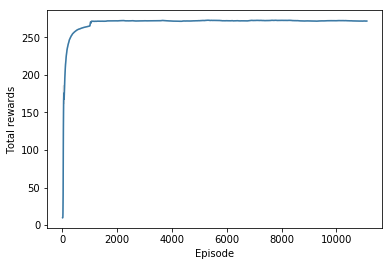

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

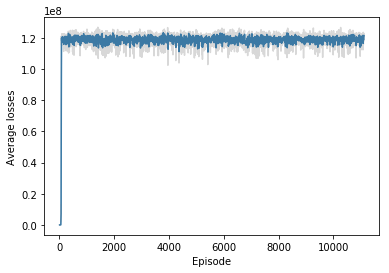

In [21]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.